This notebook generates figures for "Improving ocean carbon flux decadal prediction skill using Observationally-constrained statistical models" manuscript.

In [1]:
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import nc_time_axis
import xesmf as xe
import wget
import glob
import numpy as np
import warnings
warnings.filterwarnings('ignore') # don't output warnings
import cftime
import pandas as pd
from pandas.core.nanops import nanmean as pd_nanmean
import scipy
from scipy import stats
import statsmodels.nonparametric.smoothers_lowess

Define analysis functions:

In [2]:

## Area weigh maps based on grid cell area. By feeding biomes and biome_num you can area weigh the maps in a specific biome.

def area_weigh(ds, biomes = None, biome_num = None):
    if biome_num == None:
        return (ds*(area - (ds-ds))).sum(['lat', 'lon'])/ (area - (ds-ds)).sum(['lat','lon'])
    else:
        return ((ds.where(biomes == biome_num))*((area - (ds-ds)).where(biomes == biome_num))).sum(['lat', 'lon'])/ (area - (ds-ds)).where(biomes == biome_num).sum(['lat','lon'])

### Calculate a linear fit to the data over 1990-2019

def poli(data):
  ds = data.copy()
#   time = np.arange(1990,2020,1/12)  ### run this instead if you want monthly means
  time = np.arange(1990,2020,1) ### run this instead if you want annual means
  T = ds['time']
  ds['time'] = time
  m = ds.polyfit( dim  = 'time', deg = 1).polyfit_coefficients
  
  out = m[0]*ds.time +  m[1]
  out['time'] = T
  del ds
  del T
  return m[0], out


### remove 1990-2019 repeating seasonal cycle  from entire time line.

def deseason(ds):
    clim = ds.sel(time = slice('1990','2019')).groupby('time.month').mean()
    ds2 = ds.copy()
    for i in range(0,len(ds.time),12):

        ds2[i:i+12,:,:] = clim
    return ds - ds2


### remove ice biomes from Fay & McKinley (2014). NOTE: have to load biomes first.
def remove_ice(ds, fake = None):
    ds1 = ds.where(biomes != 1)
    ds1 = ds1.where(biomes != 8)
    ds1 = ds1.where(biomes != 17)
    return ds1


### Calculate the ocean area covered by a data product
def Area(ds):
    return (area - (ds-ds)).sum(['lat','lon'])

### Integrate maps of mol/m2/yr into global estimates in pGC/yr
def to_pgyr(ds):
    out =  ((ds * area).sum(['lat','lon'])) * 12/1000 / 1e12
    return out  


### remove a linear trend 
def detrend(ds):
    try:
        out = ds - poli(ds)[1]
    except:
        out = ds - poli_mn(ds)[1]
        
    return out


### Root mean square error
def rmse(ds1,ds2):
    
    return np.sqrt(((ds1 - ds2)**2).mean())

Bootstraping functions:

In [3]:


### Generate a randomly shuffled (with replacement) time index array with consecutive years 
### being 5 years separeted for bootstraping.

def randgen_lag_corr(years):
    import random
    ls = (np.zeros(years)).astype('int')
    for i in range(years):
        if i == 0:         
            ls[i] = random.choices(np.arange(years))[0] 
        else:
            okay = True
            while okay:
                temp = random.choices(np.arange(years))[0]
                if np.abs( temp - ls[i-1])>5:
                    ls[i] = temp 
                    okay = False
    return ls 


## Shuffle the ensemble members at each time index.
def member_shuffle(ds, mem):
    
    return [ds[mem[:,i],i].mean('member').values.tolist() for i in range(30)]


## Calculate confidence interval based on the distribution acquried from bootstraping
def _confint(ds,alpha):
    
    mean = ds.median()
    max = ds.max()
    min = ds.min()
    D = xr.concat([ds for i in range(10000)], dim = 'fake')
    ranges = xr.DataArray(np.arange(10000) * np.min([max - mean, mean - min])/1000, dims = 'fake')
    ind = (D.where((D<D.median('samples') + ranges)&(D>D.median('samples') - ranges)).count('samples')/1000).values
    return (D.median('samples') - ranges)[np.argmax(ind>alpha)] ,  (D.median('samples') + ranges)[np.argmax(ind>alpha)], ind[np.argmax(ind>alpha)]

## Calculate p_values as values where the difference in correlations is smaller than zero (Goddard et al., 2013).
def p_value(ds):

    return len(ds.where(ds<0, drop = True))/len(ds)


Load observational predictor data:

In [4]:
atm = xr.open_dataset('/fs/ccchome/acrnrpg/DCPP-local/atm_historical_obs_1972-2020.nc').rename({'__xarray_dataarray_variable__' : 'xCO2atm'}).xCO2atm.sel(time = slice(f'{1990}',f'{2019}'))
obs = xr.open_dataset('/fs/ccchome/acrnrpg/DCPP-local/Linear_regression/obs_predictors.nc').drop('mld').sel(time = slice(f'{1990}',f'{2019}'))
wind = xr.open_dataset('/fs/ccchome/acrnrpg/DCPP-local/wind/wind_obs_1982-2020.nc').wind.sel(time = slice(f'{1990}',f'{2019}'))

obs = xr.combine_by_coords([obs, wind, deseason(wind).to_dataset(name = 'wind_anom')])
obs['atm_anom'] = deseason(obs.atm)
obs['sst_anom'] = deseason(obs.sst)
obs['sss_anom'] = deseason(obs.sss)
obs['chl_anom'] = deseason(obs.chl)

Load area.nc containing area per grid cell in a normal one-by-one degree resolution and biome of your choice (here Fay & McKinely; 2014).

In [5]:
area = xr.open_dataset('/fs/ccchome/acrnrpg/DCPP-local/area_obs.nc').area
biomes = xr.open_dataset('/fs/ccchome/acrnrpg/DCPP-local/Time_Varying_Biomes.nc').MeanBiomes
BIO = ['North Pacific Ice',
'North Pacific Subpolar Seasonally Stratified',
'North Pacific Subtropical Seasonally Stratified',
 'North Pacific Subtropical Permanently Stratified',
'West Pacific Equatorial',
'East Pacific Equatorial',
'South Pacific Subtropical Permanently Stratified',
'(Omitted) North Atlantic Ice',
'North Atlantic Subpolar Seasonally Stratified',
'North Atlantic Subtropical Seasonally Stratified',
'North Atlantic Subtropical Permanently Stratified',
'Atlantic Equatorial',
'South Atlantic Subtropical Permanently Stratified',
'Indian Ocean Subtropical Permanently Stratified',
'Southern Ocean Subtropical Seasonally Stratified',
'Southern Ocean Subpolar Seasonally Stratified',
'Southern Ocean Ice']

Load CanESM5 raw fgco2 estimates from assimilation, historical and hindcasts. 
These are large ensembles of annual mean anomalies relative to 1990-2019.
NOTE: You can adjust the code in scripts/CanESM5_data.py to load the data and calculate annual mean anomalies relative
to 1990-2019. By adjusting the code, you can have large ensembles or ensemble means.

In [6]:
from tqdm import tqdm
ly_dict = {}

for i in tqdm(range(1,11)):
    

    ly_dict[i] = xr.open_dataset('/fs/ccchome/acrnrpg/DCPP-local/1982-2020_hindcast/CanESM5_hindcast_fgco2_annual_mean_anom_1982-2020_EM_regridded.nc')[f'ly{i}'].sel(time = slice('1990','2019'))


fgco2_assim = xr.open_dataset('/fs/ccchome/acrnrpg/DCPP-local/CanESM5_fgco2_assim_anomaly_1990-2019_EM.nc').fgco2
fgco2_hist = xr.open_dataset('/fs/ccchome/acrnrpg/DCPP-local/CanESM5_fgco2_hist_anomaly_1990-2019_LE.nc').fgco2

100%|██████████| 10/10 [00:00<00:00, 25.53it/s]


Load SeaFlux obsearvation based ocean carbon flux estimate:

In [7]:
sink =  xr.open_dataset('/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/SeaFlux_v2021.04_fgco2_all_winds_products.nc?download=1', engine = 'netcdf4').sel(wind = 'ERA5').fgco2
sink['time'] = obs.sel(time = slice('1990','2019'))['time']

## Figure 1

Define a function to output annual mean anomalies relative to 1990-2019 for your reference observational product of choice (ref_name), and reconstruction data 
from NN and Linear models trained on the data product of choice (name).

In [8]:
def timeseries_data(name, ref_name):

    import matplotlib.transforms as transforms
    if ref_name == 'Mean':
        
        ref = sink.mean('product')
    else:
        ref = sink.sel(product = ref_name) 
        
    if name == 'Mean':
        recons_NN = xr.open_dataset(f'/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/NN_models/SeaFlux/Mean/Output/recons_Mean_annual_SOMFFN_sigmoid15.nc').fgco2
        recons_Lin = xr.open_dataset(f'/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Linear_models/SeaFlux/MEAN/recons_MEAN_linear.nc').fgco2
    else:
        recons_NN = xr.open_dataset(f'/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/NN_models/SeaFlux/{name}/Output/recons_{name}_annual_SOMFFN_sigmoid15.nc').fgco2
        recons_Lin = xr.open_dataset(f'/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Linear_models/SeaFlux/{name}/recons_{name}_linear.nc').fgco2

  
    recons_Lin = recons_Lin.resample(time = 'Y').mean()
    recons_NN = recons_NN.resample(time = 'Y').mean()
    recons_NN = recons_NN - recons_NN.mean('time')
    recons_Lin = recons_Lin - recons_Lin.mean('time')

    sink_obs = deseason(ref).resample(time = 'Y').mean()
    
    return recons_Lin, recons_NN, sink_obs
    

Generate reconstruction data using NN and Linear models trained on each of the individual SeaFlux products (predictants) and calculate global time series. 
These are used to acquire ranges in Figure 1.

In [15]:
NN_ts = {}
Lin_ts = {}
obs_ts = {}
for name in ['JENA_MLS', 'MPI_SOMFFN', 'CMEMS_FFNN', 'CSIR_ML6', 'JMA_MLR',  'NIES_FNN']:

    recons_Lin, recons_NN, sink_obs = timeseries_data(name, name)

    obs_ts[name] = to_pgyr(sink_obs) 
    NN_ts[name]  = to_pgyr(recons_NN) * Area(sink_obs)/Area(recons_NN)  ## Adjust the global ocean carbon flux value based on area coverage of the reference observational data.
    Lin_ts[name] = to_pgyr(recons_Lin).drop('param') * Area(sink_obs)/Area(recons_Lin)
    
obs_ts = xr.concat(list(obs_ts.values()), dim = 'product')
Lin_ts = xr.concat(list(Lin_ts.values()), dim = 'product')
NN_ts = xr.concat(list(NN_ts.values()), dim = 'product')

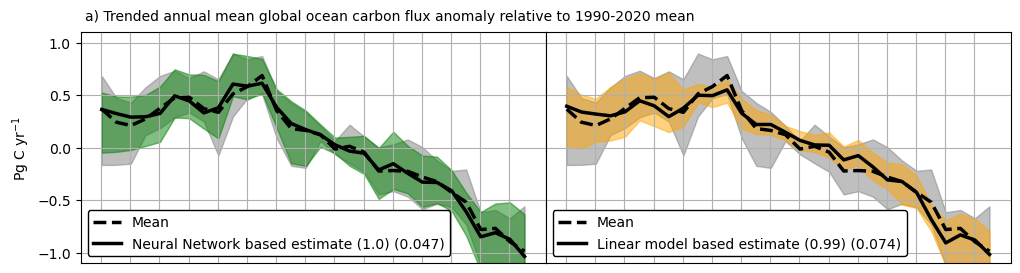

In [16]:
import matplotlib.transforms as transforms

ticks = [cftime.DatetimeNoLeap(year, 12, 16, 0, 0, 0, 0, has_year_zero=True) for year in range(1990,2020,2)]
labels = np.arange(1990,2020,2)
plt.figure( figsize = (12,3))


ax = plt.subplot(1,2,1) ## NN models

## ranges
ax.fill_between(obs_ts.time.values, obs_ts.min('product').values,   obs_ts.max('product').values, alpha = 0.5, color = 'grey')
ax.fill_between(NN_ts.time.values,  NN_ts.min('product').values,   NN_ts.max('product').values, alpha = 0.5, color = 'green')

## load reconstruction data trained on MEAN
recons_Lin, recons_NN, sink_obs = timeseries_data('Mean', 'Mean')

ds1 = to_pgyr((sink_obs)) 
ds1.plot(color = 'k',linestyle = 'dashed', label = f'Mean', linewidth = 2.5)

ds = to_pgyr(recons_NN)* Area(sink_obs)/Area(recons_NN) ## Adjust values based on observational data area coverage
corr = xr.corr(ds, ds1, dim = 'time').values ## time series correlations
rsme = rmse(ds, ds1).values ## time root mean square error
ds.plot(color = 'k', label = f'Neural Network based estimate ({np.round(corr,2)}) ({np.round(rsme,3)})', linewidth = 2.5)

plt.ylabel(r'Pg C yr$^{-1}$')
plt.title('')
legend = plt.legend( framealpha = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('k')
ax.set_xticks(ticks)
ax.set_xlabel('')
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.ylim([-1.1,1.1])
plt.grid('on')
ax.text(0.01,1.05, 'a) Trended annual mean global ocean carbon flux anomaly relative to 1990-2020 mean', transform=ax.transAxes)

ax = plt.subplot(1,2,2) ## Linear models


ax.fill_between(obs_ts.time.values, obs_ts.min('product').values,   obs_ts.max('product').values, alpha = 0.5, color = 'grey')
ax.fill_between(Lin_ts.time.values,  Lin_ts.min('product').values,  Lin_ts.max('product').values, alpha = 0.5, color = 'orange')

ds1 = to_pgyr((sink_obs))
ds1.plot(color = 'k',linestyle = 'dashed', label = f'Mean', linewidth = 2.5)

ds = to_pgyr((recons_Lin))* Area(sink_obs)/Area(recons_Lin)
corr = xr.corr(ds, ds1, dim = 'time').values
rsme = rmse(ds, ds1).values
ds.plot(color = 'k', label = f'Linear model based estimate ({np.round(corr,2)}) ({np.round(rsme,3)})', linewidth = 2.5)

plt.title('')
legend = plt.legend( framealpha = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('k')
ax.set_xticks(ticks)
ax.set_xlabel('')
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

ax.set_ylabel('')
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)
plt.grid('on')
plt.ylim([-1.1,1.1])

plt.subplots_adjust(wspace=0, hspace=0)

Same as above but detrended:

In [17]:
NN_ts = {}
Lin_ts = {}
obs_ts = {}
for name in ['JENA_MLS', 'MPI_SOMFFN', 'CMEMS_FFNN', 'CSIR_ML6', 'JMA_MLR',  'NIES_FNN']:

    recons_Lin, recons_NN, sink_obs = timeseries_data(name, name)

    obs_ts[name] = detrend(to_pgyr(sink_obs))
    NN_ts[name]  = detrend(to_pgyr(recons_NN) * Area(sink_obs)/Area(recons_NN))
    Lin_ts[name] = detrend(to_pgyr(recons_Lin).drop('param')  * Area(sink_obs)/Area(recons_Lin))
    
obs_ts = xr.concat(list(obs_ts.values()), dim = 'product')
Lin_ts = xr.concat(list(Lin_ts.values()), dim = 'product')
NN_ts = xr.concat(list(NN_ts.values()), dim = 'product')

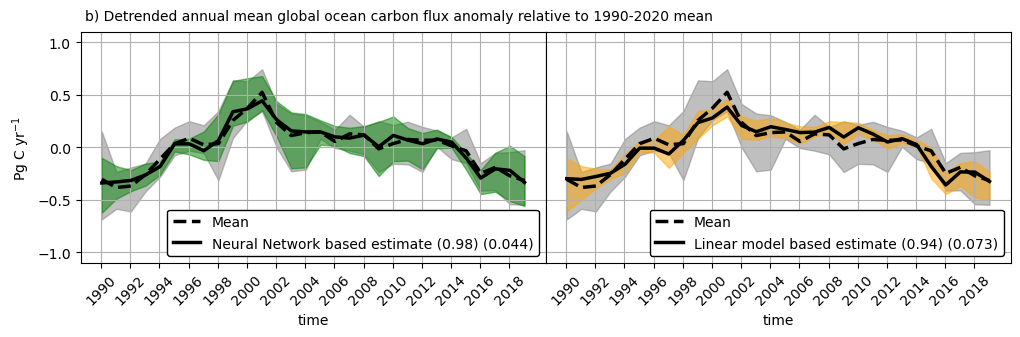

In [18]:
import matplotlib.transforms as transforms

ticks = [cftime.DatetimeNoLeap(year, 12, 16, 0, 0, 0, 0, has_year_zero=True) for year in range(1990,2020,2)]
labels = np.arange(1990,2020,2)


plt.figure( figsize = (12,3))



ax = plt.subplot(1,2,1)

ax.fill_between(obs_ts.time.values, obs_ts.min('product').values,   obs_ts.max('product').values, alpha = 0.5, color = 'grey')
ax.fill_between(NN_ts.time.values,  NN_ts.min('product').values,   NN_ts.max('product').values, alpha = 0.5, color = 'green')

recons_Lin, recons_NN, sink_obs = timeseries_data('Mean', 'Mean')

ds1 = detrend(to_pgyr((sink_obs)))
ds1.plot(color = 'k',linestyle = 'dashed', label = f'Mean', linewidth = 2.5)

ds = detrend(to_pgyr(recons_NN)* Area(sink_obs)/Area(recons_NN))
corr = xr.corr(ds, ds1, dim = 'time').values
rsme = rmse(ds, ds1).values
ds.plot(color = 'k', label = f'Neural Network based estimate ({np.round(corr,2)}) ({np.round(rsme,3)})', linewidth = 2.5)

plt.ylabel(r'Pg C yr$^{-1}$')
plt.title('')
plt.xlabel('time')
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation = 45)
legend = plt.legend( framealpha = 1, loc = 'lower right')
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('k')

plt.ylim([-1.1,1.1])
plt.grid('on')
ax.text(0.01,1.05, 'b) Detrended annual mean global ocean carbon flux anomaly relative to 1990-2020 mean', transform=ax.transAxes)

ax = plt.subplot(1,2,2)

ax.fill_between(obs_ts.time.values, obs_ts.min('product').values,   obs_ts.max('product').values, alpha = 0.5, color = 'grey')
ax.fill_between(Lin_ts.time.values,  Lin_ts.min('product').values,  Lin_ts.max('product').values, alpha = 0.5, color = 'orange')

ds1 = detrend(to_pgyr((sink_obs)))
ds1.plot(color = 'k',linestyle = 'dashed', label = f'Mean', linewidth = 2.5)

ds = detrend(to_pgyr(recons_Lin)* Area(sink_obs)/Area(recons_Lin))
corr = xr.corr(ds, ds1, dim = 'time').values
rsme = rmse(ds, ds1).values
ds.plot(color = 'k', label = f'Linear model based estimate ({np.round(corr,2)}) ({np.round(rsme,3)})', linewidth = 2.5)

plt.title('')

plt.xlabel('time')
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation = 45)
plt.ylim([-1.1,1.1])
plt.grid('on')
legend = plt.legend( framealpha = 1, loc = 'lower right')
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('k')
ax.set_ylabel('')
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)


plt.subplots_adjust(wspace=0, hspace=0)

# Figure 2

Load NN and Linear model assimilation runs trained on individual SeaFlux products (predictants):

In [21]:
Lin_assim = xr.combine_by_coords( [xr.open_dataset(f'/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Linear_models/SeaFlux/{data}/assim_{data}_annual_lienar.nc').drop(['product','param','wind','height']).rename({'fgco2' : data}) for data in 
                                     ['JENA_MLS', 'MPI_SOMFFN', 'CMEMS_FFNN', 'CSIR_ML6', 'JMA_MLR',  'NIES_FNN']])

Lin_assim = xr.combine_by_coords([Lin_assim,xr.open_dataset(f'/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Linear_models/SeaFlux/MEAN/assim_MEAN_annual_lienar.nc').drop(['param','wind','height']).rename({'fgco2' : 'Mean'})])
Lin_assim = Lin_assim.resample(time = 'Y').mean() - Lin_assim.mean('time')

NN_assim = xr.combine_by_coords( [xr.open_dataset(f'/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/NN_models/SeaFlux/{data}/Output/assim_{data}_annual_SOMFFN_sigmoid15.nc').drop(['product','wind','height']).rename({'fgco2' : data}) for data in 
                                     ['JENA_MLS', 'MPI_SOMFFN', 'CMEMS_FFNN', 'CSIR_ML6', 'JMA_MLR',  'NIES_FNN']])
NN_assim = xr.combine_by_coords([NN_assim,xr.open_dataset(f'/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/NN_models/SeaFlux/Mean/Output/assim_Mean_annual_SOMFFN_sigmoid15.nc').drop(['wind','height']).rename({'fgco2' : 'Mean'})])

NN_assim = NN_assim - NN_assim.mean('time')

Calculate correaltion coefficeints for global fgco2 annual mean anomaly time series for each of the assimilation runs above, and each of the individual SeaFlux data products
as observational reference.

### Linear

In [22]:
print('Linear model assimilation: \n')
for ds in  ['JENA_MLS', 'MPI_SOMFFN', 'CMEMS_FFNN', 'CSIR_ML6', 'JMA_MLR',  'NIES_FNN', 'Mean']:
    
    correlations = {}

    for ref in  ['JENA_MLS', 'MPI_SOMFFN', 'CMEMS_FFNN', 'CSIR_ML6', 'JMA_MLR',  'NIES_FNN', 'Mean']:
        
        if ref == "Mean":
                
                correlations[ref] =   np.round(xr.corr(to_pgyr(Lin_assim[ds]), to_pgyr(deseason(sink.mean('product')).resample(time = 'Y').mean()), 'time').values,2)
        else:
            
                correlations[ref] =   np.round(xr.corr(to_pgyr(Lin_assim[ds]), to_pgyr(deseason(sink.sel(product = ref)).resample(time = 'Y').mean()), 'time').values,2)
        
    print( f' Trended global mean sink correlations for {ds} assimilation are: \n {correlations}')

Linear model assimilation: 

 Trended global mean sink correlations for JENA_MLS assimilation are: 
 {'JENA_MLS': 0.86, 'MPI_SOMFFN': 0.89, 'CMEMS_FFNN': 0.99, 'CSIR_ML6': 0.98, 'JMA_MLR': 0.87, 'NIES_FNN': 0.96, 'Mean': 0.98}
 Trended global mean sink correlations for MPI_SOMFFN assimilation are: 
 {'JENA_MLS': 0.86, 'MPI_SOMFFN': 0.9, 'CMEMS_FFNN': 0.99, 'CSIR_ML6': 0.98, 'JMA_MLR': 0.86, 'NIES_FNN': 0.96, 'Mean': 0.98}
 Trended global mean sink correlations for CMEMS_FFNN assimilation are: 
 {'JENA_MLS': 0.85, 'MPI_SOMFFN': 0.88, 'CMEMS_FFNN': 0.99, 'CSIR_ML6': 0.98, 'JMA_MLR': 0.86, 'NIES_FNN': 0.97, 'Mean': 0.98}
 Trended global mean sink correlations for CSIR_ML6 assimilation are: 
 {'JENA_MLS': 0.85, 'MPI_SOMFFN': 0.89, 'CMEMS_FFNN': 0.98, 'CSIR_ML6': 0.99, 'JMA_MLR': 0.81, 'NIES_FNN': 0.96, 'Mean': 0.97}
 Trended global mean sink correlations for JMA_MLR assimilation are: 
 {'JENA_MLS': 0.78, 'MPI_SOMFFN': 0.86, 'CMEMS_FFNN': 0.93, 'CSIR_ML6': 0.89, 'JMA_MLR': 0.98, 'NIES_FNN':

In [23]:
print('Linear model assimilation: \n')

for ds in  ['JENA_MLS', 'MPI_SOMFFN', 'CMEMS_FFNN', 'CSIR_ML6', 'JMA_MLR',  'NIES_FNN', 'Mean']:
    
    correlations = {}

    for ref in  ['JENA_MLS', 'MPI_SOMFFN', 'CMEMS_FFNN', 'CSIR_ML6', 'JMA_MLR',  'NIES_FNN', 'Mean']:
        if ref != 'Mean':
            
                correlations[ref] =   np.round(xr.corr(detrend(to_pgyr(Lin_assim[ds])), detrend(to_pgyr(deseason(sink.sel(product = ref)).resample(time = 'Y').mean())), 'time').values,2)
        else:
            
                correlations[ref] =   np.round(xr.corr(detrend(to_pgyr(Lin_assim[ds])), detrend(to_pgyr(deseason(sink.mean('product')).resample(time = 'Y').mean())), 'time').values,2)
        
    print( f' Detrended global mean sink correlations for {ds} assimilation are: \n {correlations}')

Linear model assimilation: 

 Detrended global mean sink correlations for JENA_MLS assimilation are: 
 {'JENA_MLS': 0.58, 'MPI_SOMFFN': 0.65, 'CMEMS_FFNN': 0.92, 'CSIR_ML6': 0.88, 'JMA_MLR': 0.88, 'NIES_FNN': 0.79, 'Mean': 0.89}
 Detrended global mean sink correlations for MPI_SOMFFN assimilation are: 
 {'JENA_MLS': 0.56, 'MPI_SOMFFN': 0.69, 'CMEMS_FFNN': 0.92, 'CSIR_ML6': 0.89, 'JMA_MLR': 0.87, 'NIES_FNN': 0.8, 'Mean': 0.9}
 Detrended global mean sink correlations for CMEMS_FFNN assimilation are: 
 {'JENA_MLS': 0.51, 'MPI_SOMFFN': 0.62, 'CMEMS_FFNN': 0.94, 'CSIR_ML6': 0.87, 'JMA_MLR': 0.94, 'NIES_FNN': 0.88, 'Mean': 0.91}
 Detrended global mean sink correlations for CSIR_ML6 assimilation are: 
 {'JENA_MLS': 0.55, 'MPI_SOMFFN': 0.7, 'CMEMS_FFNN': 0.94, 'CSIR_ML6': 0.92, 'JMA_MLR': 0.9, 'NIES_FNN': 0.84, 'Mean': 0.92}
 Detrended global mean sink correlations for JMA_MLR assimilation are: 
 {'JENA_MLS': 0.5, 'MPI_SOMFFN': 0.68, 'CMEMS_FFNN': 0.95, 'CSIR_ML6': 0.9, 'JMA_MLR': 0.97, 'NIES_

Add the scores above into pandas dataframe for heatmaps:

In [22]:
import pandas as pd
  
data = {'JENA_MLS': [0.58,0.56,0.51,0.55,0.5,0.43,0.53,0.29],
        'MPI_SOMFFN': [0.65 ,0.69 ,0.62 ,0.70 ,0.68 ,0.59 ,0.67 ,0.42],
        'CMEMS_FFNN': [0.92 ,0.92 ,0.94 ,0.94 ,0.95 ,0.86 ,0.95 ,0.43],
        'CSIR_ML6': [0.88 ,0.89 ,0.87 ,0.92 ,0.90 ,0.80 ,0.90 ,0.43],
        'JMA_MLR': [0.88 ,0.87 ,0.94 ,0.90 ,0.97 ,0.95 ,0.96 ,0.44],
        'NIES_FNN': [0.79 ,0.80 ,0.88 ,0.84 ,0.94 ,1.00 ,0.92 ,0.49],
        'Mean': [0.89 ,0.90 ,0.91 ,0.92 ,0.94 ,0.89 ,0.94 ,0.48]}
        
  
# Creates pandas DataFrame.
df = pd.DataFrame(data, index=['JENA_MLS', 'MPI_SOMFFN', 'CMEMS_FFNN', 'CSIR_ML6', 'JMA_MLR',  'NIES_FNN', 'Mean', 'CanESM5'])
  
# add an extra column calculating the mean of each row except the diagonal value.

EXT = np.round((df.sum(axis=1).values - [0.58,0.69,0.94,0.92,0.97,1,0.94,np.nan])/6,2)

# Add the EXT as a new column to the DataFrame
df['EXT'] = EXT
df

JENA_MLS  MPI_SOMFFN  CMEMS_FFNN  CSIR_ML6  JMA_MLR  NIES_FNN  \
JENA_MLS        0.58        0.65        0.92      0.88     0.88      0.79   
MPI_SOMFFN      0.56        0.69        0.92      0.89     0.87      0.80   
CMEMS_FFNN      0.51        0.62        0.94      0.87     0.94      0.88   
CSIR_ML6        0.55        0.70        0.94      0.92     0.90      0.84   
JMA_MLR         0.50        0.68        0.95      0.90     0.97      0.94   
NIES_FNN        0.43        0.59        0.86      0.80     0.95      1.00   
Mean            0.53        0.67        0.95      0.90     0.96      0.92   
CanESM5         0.29        0.42        0.43      0.43     0.44      0.49   

            Mean   EXT  
JENA_MLS    0.89  0.83  
MPI_SOMFFN  0.90  0.82  
CMEMS_FFNN  0.91  0.79  
CSIR_ML6    0.92  0.81  
JMA_MLR     0.94  0.82  
NIES_FNN    0.89  0.75  
Mean        0.94  0.82  
CanESM5     0.48   NaN

Text(0.01, 1.05, 'b) Linear model detrended assimilation')

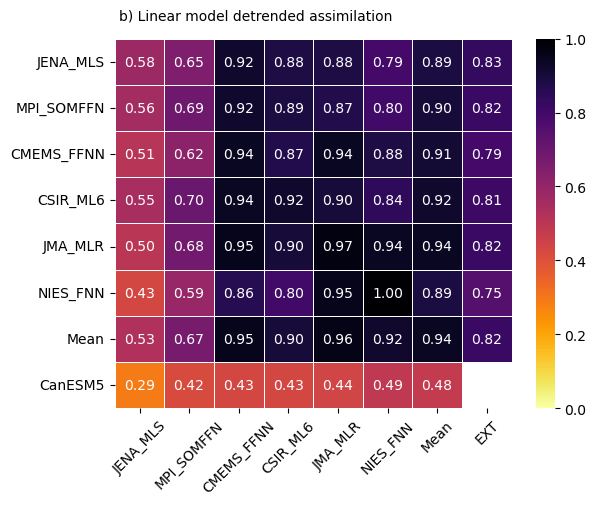

In [23]:
import seaborn as sns
ax = sns.heatmap(df, annot=True, fmt=".2f", vmin = 0, vmax = 1, cmap = 'inferno_r',linewidth=.5)
plt.xticks(rotation=45)
plt.text(0.01,1.05, 'b) Linear model detrended assimilation', transform=ax.transAxes)


### NN

In [24]:
print('NN model assimilation: \n')
for ds in  ['JENA_MLS', 'MPI_SOMFFN', 'CMEMS_FFNN', 'CSIR_ML6', 'JMA_MLR',  'NIES_FNN', 'Mean']:
    
    correlations = {}

    for ref in  ['JENA_MLS', 'MPI_SOMFFN', 'CMEMS_FFNN', 'CSIR_ML6', 'JMA_MLR',  'NIES_FNN', "Mean"]:
        
        if ref != 'Mean':

            correlations[ref] =   np.round(xr.corr(to_pgyr(NN_assim[ds]), to_pgyr(deseason(sink.sel(product = ref)).resample(time = 'Y').mean()), 'time').values,2)
       
        else:
            
            correlations[ref] =   np.round(xr.corr(to_pgyr(NN_assim[ds]), to_pgyr(deseason(sink.mean('product')).resample(time = 'Y').mean()), 'time').values,2)

            
    print( f' Trended global mean sink correlations for {ds} assimilation are: \n {correlations}')

NN model assimilation: 

 Trended global mean sink correlations for JENA_MLS assimilation are: 
 {'JENA_MLS': 0.92, 'MPI_SOMFFN': 0.89, 'CMEMS_FFNN': 0.92, 'CSIR_ML6': 0.94, 'JMA_MLR': 0.83, 'NIES_FNN': 0.88, 'Mean': 0.94}
 Trended global mean sink correlations for MPI_SOMFFN assimilation are: 
 {'JENA_MLS': 0.81, 'MPI_SOMFFN': 0.99, 'CMEMS_FFNN': 0.89, 'CSIR_ML6': 0.93, 'JMA_MLR': 0.78, 'NIES_FNN': 0.87, 'Mean': 0.93}
 Trended global mean sink correlations for CMEMS_FFNN assimilation are: 
 {'JENA_MLS': 0.83, 'MPI_SOMFFN': 0.88, 'CMEMS_FFNN': 0.99, 'CSIR_ML6': 0.98, 'JMA_MLR': 0.86, 'NIES_FNN': 0.97, 'Mean': 0.97}
 Trended global mean sink correlations for CSIR_ML6 assimilation are: 
 {'JENA_MLS': 0.86, 'MPI_SOMFFN': 0.92, 'CMEMS_FFNN': 0.98, 'CSIR_ML6': 0.99, 'JMA_MLR': 0.82, 'NIES_FNN': 0.96, 'Mean': 0.98}
 Trended global mean sink correlations for JMA_MLR assimilation are: 
 {'JENA_MLS': 0.75, 'MPI_SOMFFN': 0.83, 'CMEMS_FFNN': 0.88, 'CSIR_ML6': 0.84, 'JMA_MLR': 0.97, 'NIES_FNN': 0.

In [25]:
print('NN model assimilation: \n')

for ds in  ['JENA_MLS', 'MPI_SOMFFN', 'CMEMS_FFNN', 'CSIR_ML6', 'JMA_MLR',  'NIES_FNN', 'Mean']:
    
    correlations = {}

    for ref in  ['JENA_MLS', 'MPI_SOMFFN', 'CMEMS_FFNN', 'CSIR_ML6', 'JMA_MLR',  'NIES_FNN', "Mean"]:
        
        if ref != 'Mean':
            
             correlations[ref] =   np.round(xr.corr(detrend(to_pgyr(NN_assim[ds])), detrend(to_pgyr(deseason(sink.sel(product = ref)).resample(time = 'Y').mean())), 'time').values,2)

        else:
            
             correlations[ref] =   np.round(xr.corr(detrend(to_pgyr(NN_assim[ds])), detrend(to_pgyr(deseason(sink.mean('product')).resample(time = 'Y').mean())), 'time').values,2)
        
    print( f' Detrended global mean sink correlations for {ds} assimilation are: \n {correlations}')

NN model assimilation: 

 Detrended global mean sink correlations for JENA_MLS assimilation are: 
 {'JENA_MLS': 0.77, 'MPI_SOMFFN': 0.67, 'CMEMS_FFNN': 0.66, 'CSIR_ML6': 0.76, 'JMA_MLR': 0.71, 'NIES_FNN': 0.52, 'Mean': 0.78}
 Detrended global mean sink correlations for MPI_SOMFFN assimilation are: 
 {'JENA_MLS': 0.45, 'MPI_SOMFFN': 0.96, 'CMEMS_FFNN': 0.58, 'CSIR_ML6': 0.81, 'JMA_MLR': 0.56, 'NIES_FNN': 0.51, 'Mean': 0.75}
 Detrended global mean sink correlations for CMEMS_FFNN assimilation are: 
 {'JENA_MLS': 0.46, 'MPI_SOMFFN': 0.57, 'CMEMS_FFNN': 0.96, 'CSIR_ML6': 0.84, 'JMA_MLR': 0.87, 'NIES_FNN': 0.83, 'Mean': 0.86}
 Detrended global mean sink correlations for CSIR_ML6 assimilation are: 
 {'JENA_MLS': 0.59, 'MPI_SOMFFN': 0.82, 'CMEMS_FFNN': 0.89, 'CSIR_ML6': 0.96, 'JMA_MLR': 0.85, 'NIES_FNN': 0.79, 'Mean': 0.93}
 Detrended global mean sink correlations for JMA_MLR assimilation are: 
 {'JENA_MLS': 0.51, 'MPI_SOMFFN': 0.68, 'CMEMS_FFNN': 0.9, 'CSIR_ML6': 0.86, 'JMA_MLR': 0.94, 'NIES

Add the scores above into pandas dataframe for heatmaps:

In [100]:
import pandas as pd
  
data = {'JENA_MLS': [0.77,0.45,0.46,0.59,0.51,0.42,0.58,0.29],
        'MPI_SOMFFN': [0.67 ,0.96 ,0.57 ,0.82 ,0.68 ,0.64 ,0.82 ,0.42],
        'CMEMS_FFNN': [0.66 ,0.58 ,0.96 ,0.89 ,0.90 ,0.89 ,0.92 ,0.43],
        'CSIR_ML6': [0.76 ,0.81 ,0.84 ,0.96 ,0.86 ,0.83 ,0.95 ,0.43],
        'JMA_MLR': [0.71 ,0.56 ,0.87 ,0.85 ,0.94 ,0.93 ,0.93 ,0.44],
        'NIES_FNN': [0.52 ,0.51 ,0.83 ,0.79 ,0.90 ,0.99 ,0.89 ,0.49],
        'Mean': [0.78 ,0.75 ,0.86 ,0.93 ,0.91 ,0.90 ,0.97 ,0.48]}
        
  
# Creates pandas DataFrame.
df = pd.DataFrame(data, index=['JENA_MLS', 'MPI_SOMFFN', 'CMEMS_FFNN', 'CSIR_ML6', 'JMA_MLR',  'NIES_FNN', 'Mean', 'CanESM5'])
  

EXT = np.round((df.sum(axis=1).values - [0.77,0.96,0.96,0.96,0.94,0.99,0.97,np.nan])/6,2)

# Add the EXT as a new column to the DataFrame
df['EXT'] = EXT
df

JENA_MLS  MPI_SOMFFN  CMEMS_FFNN  CSIR_ML6  JMA_MLR  NIES_FNN  \
JENA_MLS        0.77        0.67        0.66      0.76     0.71      0.52   
MPI_SOMFFN      0.45        0.96        0.58      0.81     0.56      0.51   
CMEMS_FFNN      0.46        0.57        0.96      0.84     0.87      0.83   
CSIR_ML6        0.59        0.82        0.89      0.96     0.85      0.79   
JMA_MLR         0.51        0.68        0.90      0.86     0.94      0.90   
NIES_FNN        0.42        0.64        0.89      0.83     0.93      0.99   
Mean            0.58        0.82        0.92      0.95     0.93      0.89   
CanESM5         0.29        0.42        0.43      0.43     0.44      0.49   

            Mean   EXT  
JENA_MLS    0.78  0.68  
MPI_SOMFFN  0.75  0.61  
CMEMS_FFNN  0.86  0.74  
CSIR_ML6    0.93  0.81  
JMA_MLR     0.91  0.79  
NIES_FNN    0.90  0.77  
Mean        0.97  0.85  
CanESM5     0.48   NaN

Text(0.01, 1.05, 'a) NN model detrended assimilation')

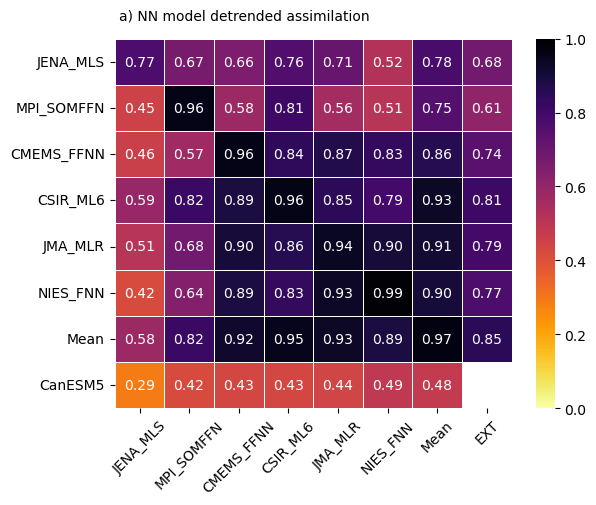

In [101]:
import seaborn as sns
ax = sns.heatmap(df, annot=True, fmt=".2f", vmin = 0, vmax = 1, cmap = 'inferno_r',linewidth=.5)
plt.xticks(rotation=45)
plt.text(0.01,1.05, 'a) NN model detrended assimilation', transform=ax.transAxes)


### CanESM5 assimilation skills

In [26]:
print(f'CanESM5 assimilation: \n')

    
correlations = {}

for ref in  ['JENA_MLS', 'MPI_SOMFFN', 'CMEMS_FFNN', 'CSIR_ML6', 'JMA_MLR',  'NIES_FNN', "Mean"]:
        
        if ref != 'Mean':
            
            correlations[ref] =   np.round(xr.corr((to_pgyr(fgco2_assim)), (to_pgyr(deseason(sink.sel(product = ref)).resample(time = 'Y').mean())), 'time').values,2)
        else:
            
            correlations[ref] =   np.round(xr.corr((to_pgyr(fgco2_assim)), (to_pgyr(deseason(sink.mean('product')).resample(time = 'Y').mean())), 'time').values,2)

            
print( f'Trended global mean sink correlations for CanESM5 assimilation are {correlations}')

CanESM5 assimilation: 

Trended global mean sink correlations for CanESM5 assimilation are {'JENA_MLS': 0.8, 'MPI_SOMFFN': 0.84, 'CMEMS_FFNN': 0.92, 'CSIR_ML6': 0.93, 'JMA_MLR': 0.72, 'NIES_FNN': 0.91, 'Mean': 0.91}


In [27]:
print(f'CanESM5 assimilation: \n')

    
correlations = {}

for ref in  ['JENA_MLS', 'MPI_SOMFFN', 'CMEMS_FFNN', 'CSIR_ML6', 'JMA_MLR',  'NIES_FNN', "Mean"]:
        
        if ref != 'Mean':
            
            correlations[ref] =   np.round(xr.corr(detrend(to_pgyr(fgco2_assim)), detrend(to_pgyr(deseason(sink.sel(product = ref)).resample(time = 'Y').mean())), 'time').values,2)
        else:
            
            correlations[ref] =   np.round(xr.corr(detrend(to_pgyr(fgco2_assim)), detrend(to_pgyr(deseason(sink.mean('product')).resample(time = 'Y').mean())), 'time').values,2)

            
print( f'Derended global mean sink correlations for CanESM5 assimilation are {correlations}')

CanESM5 assimilation: 

Derended global mean sink correlations for CanESM5 assimilation are {'JENA_MLS': 0.29, 'MPI_SOMFFN': 0.42, 'CMEMS_FFNN': 0.43, 'CSIR_ML6': 0.43, 'JMA_MLR': 0.44, 'NIES_FNN': 0.49, 'Mean': 0.48}


# Figure 3

Load hindcast, assimilation, and historical data and calculate annual mean anomalies for NN and Linear models trained on your products of choice (name).
This function also loads annual mean anomalies of your reference product of choice (ref_name).

In [13]:


def hindcast_data(name, ref_name):
    
    if ref_name == 'Mean':
        
        ref = sink.mean('product')   
    else:
        ref = sink.sel(product = ref_name)
        
    ref = ref.resample(time = 'Y').mean() - ref.mean('time')
    
    #################################### WATCH THE TIME ######################################################

    
    NN_ly_dict = {}
    for i in range(1,11):

        NN_ly_dict[i] = xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/NN_models/SeaFlux/{name}/Output/hindcast_{name}_annual_SOMFFN_sigmoid15_ly{i+1}.nc").fgco2.sel(time = slice(f'{1990}',f'{2019}')) 

    for ly in NN_ly_dict.keys():

        NN_ly_dict[ly] = (NN_ly_dict[ly].resample(time = 'Y').mean())
        NN_ly_dict[ly] = NN_ly_dict[ly] - NN_ly_dict[ly].mean('time')


    #################################### WATCH THE TIME ######################################################
    Lin_ly_dict = {}
    for i in range(1,11):
        
        if name == 'Mean':

            Lin_ly_dict[i] = xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Linear_models/SeaFlux/MEAN/hindcast_MEAN_linear_ly{i}.nc").fgco2.sel(time = slice(f'{1990}',f'{2019}')) 
         
        else:   

            Lin_ly_dict[i] = xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Linear_models/SeaFlux/{name}/hindcast_{name}_linear_ly{i}.nc").fgco2.sel(time = slice(f'{1990}',f'{2019}')) 

    for ly in Lin_ly_dict.keys():


        Lin_ly_dict[ly] = (Lin_ly_dict[ly].resample(time = 'Y').mean())
        Lin_ly_dict[ly] = Lin_ly_dict[ly] - Lin_ly_dict[ly].mean('time')


    #################################### WATCH THE TIME ######################################################

    NN_hist =  xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/NN_models/SeaFlux/{name}/Output/hist_{name}_annual_SOMFFN_sigmoid15.nc").fgco2 
    NN_assim = xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/NN_models/SeaFlux/{name}/Output/assim_{name}_annual_SOMFFN_sigmoid15.nc").fgco2 
    
    if name == 'Mean':
        
        Lin_hist = xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Linear_models/SeaFlux/MEAN/hist_MEAN_linear.nc").fgco2 
        Lin_assim = xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Linear_models/SeaFlux/MEAN/assim_MEAN_annual_lienar.nc").fgco2 
        
        
    else:

        Lin_hist = xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Linear_models/SeaFlux/{name}/hist_{name}_linear.nc").fgco2 
        Lin_assim = xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Linear_models/SeaFlux/{name}/assim_{name}_annual_lienar.nc").fgco2 

    NN_hist = NN_hist.resample(time = 'Y').mean('time') - NN_hist.mean('time')
    NN_assim = NN_assim.resample(time = 'Y').mean('time') - NN_assim.mean('time')
    Lin_hist = Lin_hist.resample(time = 'Y').mean('time') - Lin_hist.mean('time')
    Lin_assim = Lin_assim.resample(time = 'Y').mean('time') - Lin_assim.mean('time')

    return Lin_ly_dict, Lin_hist, Lin_assim, NN_ly_dict, NN_hist, NN_assim, ref

Define functions to calculate hindcast correaltion skill and bootstrap distribution:

In [14]:
## This function outputs hindcast skills for trended/detrended global annual mean anomaly time series versus your choice 
## of reference obsearvation for NN and Linear models, as well as raw CanESM5.
## The output is stored based on lead year and includes historical/assimilation skill too.

def skill_dict(model , ref, trend = True):  

        
    if trend:
            
        obs_ts = to_pgyr((ref))
        
        if model == 'Linear':   
            
            corr_dict_mean = {}
            U_ts  = to_pgyr((Lin_hist))  * Area(ref)/Area(Lin_hist)
            corr_dict_mean['Historical'] = np.round(xr.corr(U_ts, obs_ts, dim = 'time').values,2)
           
            for key, ds in Lin_ly_dict.items():

                ds_ts = to_pgyr((ds)) * Area(ref)/Area(ds)
                corr_dict_mean[f'{key}'] = np.round(xr.corr(ds_ts, obs_ts, dim = 'time').values,2)
            
            A_ts  = to_pgyr((Lin_assim)) * Area(ref)/Area(Lin_assim)
            corr_dict_mean['assim'] = np.round(xr.corr(A_ts, obs_ts, dim = 'time').values,2)
                
        elif model == 'NN':
            
            corr_dict_mean = {}
            U_ts  = to_pgyr((NN_hist))  * Area(ref)/Area(NN_hist)
            corr_dict_mean['Historical'] = np.round(xr.corr(U_ts, obs_ts, dim = 'time').values,2)
           
            for key, ds in NN_ly_dict.items():

                ds_ts = to_pgyr((ds))* Area(ref)/Area(ds)
                corr_dict_mean[f'{key}'] = np.round(xr.corr(ds_ts, obs_ts, dim = 'time').values,2)
                
            A_ts  = to_pgyr((NN_assim))* Area(ref)/Area(NN_assim)
            corr_dict_mean['assim'] = np.round(xr.corr(A_ts, obs_ts, dim = 'time').values,2)
        
        else:
            
            corr_dict_mean = {}
            U_ts  = to_pgyr((fgco2_hist.mean('member')))   * Area(ref)/Area(fgco2_hist.mean('member'))
            corr_dict_mean['Historical'] = np.round(xr.corr(U_ts, obs_ts, dim = 'time').values,2)
           
            for key, ds in ly_dict.items():

                ds_ts = to_pgyr((ds.mean('member')))* Area(ref)/Area(ds.mean('member'))
                corr_dict_mean[f'{key}'] = np.round(xr.corr(ds_ts, obs_ts, dim = 'time').values,2)
                
            A_ts  = to_pgyr((fgco2_assim)) * Area(ref)/Area(fgco2_assim)
            corr_dict_mean['assim'] = np.round(xr.corr(A_ts, obs_ts, dim = 'time').values,2)

        ## add all skills to a xarray data array and add the simulation names and l
        Corrected_skill_mean  = xr.DataArray(list(corr_dict_mean.values()), dims = ['lead_time']).assign_coords(lead_time = list(corr_dict_mean.keys()))


    
    else: 
        
        obs_ts = detrend(to_pgyr(ref))
        
        if model == 'Linear':   
            
            corr_dict_mean = {}
            U_ts  = detrend(to_pgyr(Lin_hist) * Area(ref)/Area(Lin_hist) )  
            corr_dict_mean['Historical'] = np.round(xr.corr(U_ts, obs_ts, dim = 'time').values,2)
           
            for key, ds in Lin_ly_dict.items():

                ds_ts = detrend(to_pgyr(ds) * Area(ref)/Area(ds) )
                corr_dict_mean[f'{key}'] = np.round(xr.corr(ds_ts, obs_ts, dim = 'time').values,2)
                
            A_ts  = detrend(to_pgyr(Lin_assim) * Area(ref)/Area(Lin_assim)  )
            corr_dict_mean['assim'] = np.round(xr.corr(A_ts, obs_ts, dim = 'time').values,2)
        
        elif model =='NN':
            
            corr_dict_mean = {}
            U_ts  = detrend(to_pgyr(NN_hist) * Area(ref)/Area(NN_hist) )  
            corr_dict_mean['Historical'] = np.round(xr.corr(U_ts, obs_ts, dim = 'time').values,2)
           
            for key, ds in NN_ly_dict.items():

                ds_ts = detrend(to_pgyr(ds) * Area(ref)/Area(ds) )
                corr_dict_mean[f'{key}'] = np.round(xr.corr(ds_ts, obs_ts, dim = 'time').values,2)
                
            A_ts  = detrend(to_pgyr(NN_assim) * Area(ref)/Area(NN_assim) )
            corr_dict_mean['assim'] = np.round(xr.corr(A_ts, obs_ts, dim = 'time').values,2)

        else:
            
            corr_dict_mean = {}
            U_ts  = detrend(to_pgyr(fgco2_hist.mean('member'))  * Area(ref)/Area(fgco2_hist.mean('member')) )  
            corr_dict_mean['Historical'] = np.round(xr.corr(U_ts, obs_ts, dim = 'time').values,2)
           
            for key, ds in ly_dict.items():

                ds_ts = detrend(to_pgyr(ds.mean('member')) * Area(ref)/Area(ds.mean('member')))
                corr_dict_mean[f'{key}'] = np.round(xr.corr(ds_ts, obs_ts, dim = 'time').values,2)
                
            A_ts  = detrend(to_pgyr(fgco2_assim) * Area(ref)/Area(fgco2_assim) )
            corr_dict_mean['assim'] = np.round(xr.corr(A_ts, obs_ts, dim = 'time').values,2)
        
        Corrected_skill_mean  = xr.DataArray(list(corr_dict_mean.values()), dims = ['lead_time']).assign_coords(lead_time = list(corr_dict_mean.keys()))


    return Corrected_skill_mean



## This function outputs distributions based on 1000 iteration bootstraps for NN, Linear, and raw CanESM5 historical and hisncast correlations 
## versus the reference observation of choice.

def skill_dist( ref, trend = True):

    from tqdm import tqdm
    
    if trend: ## Needs to be edited. Compare to Trend == False below.
        
            obs_ts = (to_pgyr((ref)))
            
            ########################## raw CanESM5 model ######################
            I_cor = np.zeros([10,1000])
            U_cor = np.zeros([1,1000])
            bootstrap = {}

            U_ts = (to_pgyr((fgco2_hist)))

            ly_dict_ts = {}
            for key, ds in ly_dict.items():

                ly_dict_ts[key] = (to_pgyr((ds)))   

            for it in tqdm(range(1000)):

                rng = np.random.default_rng()
#                 mem = rng.choice(20, size=[20,36], replace=True)
#                 time_sample = randgen_lag_corr(36)
                mem = rng.choice(20, size=[20,30], replace=True)
                time_sample = randgen_lag_corr(30)


                O = obs_ts[time_sample]
                U_temp = U_ts[:,time_sample]
                U_temp = member_shuffle(U_temp,mem)

                U_cor[0,it] = np.corrcoef(U_temp, O.values)[0,1]

                for key, ds in ly_dict_ts.items():

                    ds = ds[:,time_sample]
                    ds = member_shuffle(ds,mem)                

                    I_cor[key-1,it] = np.corrcoef(ds, O.values)[0,1]
                bootstrap[it] = time_sample

            CanESM5_skill_dist  = xr.DataArray(np.concatenate((U_cor,I_cor)), dims = ['lead_time','samples']).assign_coords(lead_time =keys)

            ########################## NN model ######################
            
            I_cor = np.zeros([11,1000])
            U_ts = (to_pgyr((NN_hist)))
#             Assim_ts = (area_weigh((NN_assim)))

            NN_dict_ts = {}
            for key, ds in NN_ly_dict.items():

                NN_dict_ts[key] = (to_pgyr((ds)))
            
            for it in tqdm(range(1000)):  

                rng = np.random.default_rng()

                time_sample = bootstrap[it]

                O_temp = obs_ts[time_sample]
                U_temp = U_ts[time_sample]
                              
#                 Ass_temp = Assim_ts[time_sample]

                I_cor[0,it] = xr.corr(U_temp , O_temp, dim = 'time').values
#                 I_cor[11,it] = xr.corr(Ass_temp , O_temp, dim = 'time').values

                for key, ds in NN_dict_ts.items():

                    ds = ds[time_sample]
                    I_cor[int(key),it] = xr.corr(ds, O_temp, dim = 'time').values


            lt = keys
#             lt.append('assim')
            NN_skill_dist  = xr.DataArray(I_cor, dims = ['lead_time','samples']).assign_coords(lead_time = lt)
            
            ########################## Linear model ######################
            
            I_cor = np.zeros([11,1000])
            U_ts = (to_pgyr((Lin_hist)))
#             Assim_ts = (area_weigh((Lin_assim)))


            Lin_dict_ts = {}
            for key, ds in Lin_ly_dict.items():

                Lin_dict_ts[key] = (to_pgyr((ds)))
            
            for it in tqdm(range(1000)):  

                rng = np.random.default_rng()

                time_sample = bootstrap[it]

                O_temp = obs_ts[time_sample]
                U_temp = U_ts[time_sample]
                              
#                 Ass_temp = Assim_ts[time_sample]

                I_cor[0,it] = xr.corr(U_temp , O_temp, dim = 'time').values
#                 I_cor[11,it] = xr.corr(Ass_temp , O_temp, dim = 'time').values

                for key, ds in Lin_dict_ts.items():


                    ds = ds[time_sample]
                    I_cor[int(key),it] = xr.corr(ds, O_temp, dim = 'time').values


            lt = keys
#             lt.append('assim')
            Lin_skill_dist  = xr.DataArray(I_cor, dims = ['lead_time','samples']).assign_coords(lead_time = lt)
            

    else:
            
            obs_ts = detrend(to_pgyr((ref)))
            
            ########################## raw CanESM5 model ######################
            I_cor = np.zeros([10,1000])
            U_cor = np.zeros([1,1000])
            bootstrap = {}  ## define random samples

            U_ts = detrend(to_pgyr((fgco2_hist)) * Area(ref)/Area(fgco2_hist.mean('member')) )

            ly_dict_ts = {}  ## Calculate hindcast annual mean global anomaly timeseries
            for key, ds in ly_dict.items():

                ly_dict_ts[key] = detrend(to_pgyr((ds)) * Area(ref)/Area(ds.mean('member')) )   
            
            
            for it in tqdm(range(1000)):  ### starts bootstraping

                rng = np.random.default_rng()   
                mem = rng.choice(20, size=[20,30], replace=True) ## Create random indexes for ensemble members with replacement. NOTE: only raw CanESM5 data have more than one realizations.
                time_sample = randgen_lag_corr(30) ## Create random time indexes with replacement with 5 years lag in between consecutive indexes.

                O = obs_ts[time_sample] ## Shuffle the observational reference in time.
                U_temp = U_ts[:,time_sample] ## Shuffle historical LEs in time using same indexes.
                U_temp = member_shuffle(U_temp,mem) ## Shuffle historical LEs in ensemble space

                U_cor[0,it] = np.corrcoef(U_temp, O.values)[0,1] ## Calculate correlations for the new historical sample

                for key, ds in ly_dict_ts.items(): # iterate over lead years.

   
                    ds = ds[:,time_sample] ## Shuffle hindcasts in time using same indexes.
                    ds = member_shuffle(ds,mem)       ## Shuffle hindcasts LEs  using same indexes.        

                    I_cor[key-1,it] = np.corrcoef(ds, O.values)[0,1] ## Calculate correlations for the new hindcast samples.
                bootstrap[it] = time_sample  ## save bootstrap time indexes. 

            CanESM5_skill_dist  = xr.DataArray(np.concatenate((U_cor,I_cor)), dims = ['lead_time','samples']).assign_coords(lead_time =keys)  ## save the distributions

            ########################## NN model ######################
            ### Same procedure as the raw CanESM5. The only difference is that here we do not have large ensembles, so we only shuffle data in time.

            I_cor = np.zeros([11,1000])
            U_ts = detrend(to_pgyr((NN_hist)) * Area(ref)/Area(NN_hist))           
            
            NN_ly_dict_ts = {}
            for key, ds in NN_ly_dict.items():

                NN_ly_dict_ts[key] = detrend(to_pgyr((ds))  * Area(ref)/Area(ds) )   
            
            for it in tqdm(range(1000)):  

                rng = np.random.default_rng()

                time_sample = bootstrap[it]

                O_temp = obs_ts[time_sample]
                U_temp = U_ts[time_sample]
                              


                I_cor[0,it] = xr.corr(U_temp , O_temp, dim = 'time').values

                for key, ds in NN_ly_dict_ts.items():

                    ds = ds[time_sample]
                    I_cor[int(key),it] = xr.corr(ds, O_temp, dim = 'time').values


            lt = keys
            NN_skill_dist  = xr.DataArray(I_cor, dims = ['lead_time','samples']).assign_coords(lead_time = lt)
            
            ########################## Linear model ######################
            ### Same procedure as the raw CanESM5. The only difference is that here we do not have large ensembles, so we only shuffle data in time.

            I_cor = np.zeros([11,1000])
            U_ts = detrend(to_pgyr((Lin_hist)) * Area(ref)/Area(Lin_hist) )

            
            Lin_ly_dict_ts = {}
            for key, ds in Lin_ly_dict.items():

                Lin_ly_dict_ts[key] = detrend(to_pgyr((ds)) * Area(ref)/Area(ds) ) 
            
            for it in tqdm(range(1000)):  

                rng = np.random.default_rng()

                time_sample = bootstrap[it]

                O_temp = obs_ts[time_sample]
                U_temp = U_ts[time_sample]
                              


                I_cor[0,it] = xr.corr(U_temp , O_temp, dim = 'time').values


                for key, ds in Lin_ly_dict_ts.items():

    
                    ds = ds[time_sample]
                    I_cor[int(key),it] = xr.corr(ds, O_temp, dim = 'time').values


            lt = keys
            Lin_skill_dist  = xr.DataArray(I_cor, dims = ['lead_time','samples']).assign_coords(lead_time = lt)

    return CanESM5_skill_dist, NN_skill_dist, Lin_skill_dist


keys = [f'{i}' for i in range(1,11)]
keys = ['Historical']  + keys

Find hindcast correlation skills for data products trained on individual SeaFlux products and evaluated against the MEAN. These will be plotted with crosses in the background.

In [15]:

NN_skills = {}
Lin_skills = {}
NN_dists = {}
Lin_dists = {}

for Name in ['JENA_MLS', 'MPI_SOMFFN', 'CMEMS_FFNN', 'CSIR_ML6', 'JMA_MLR',  'NIES_FNN']:
    
    Lin_ly_dict, Lin_hist, Lin_assim, NN_ly_dict, NN_hist, NN_assim, ref = hindcast_data(Name, 'Mean')
    

    NN_skills[Name] = skill_dict('NN' , ref, trend = False)
    Lin_skills[Name] = skill_dict('Linear' , ref, trend = False)


NN_skills = xr.concat(list(NN_skills.values()), dim = 'product').assign_coords(product =list(NN_skills.keys()) )
Lin_skills = xr.concat(list(Lin_skills.values()), dim = 'product').assign_coords(product =list(Lin_skills.keys()) )

Extract skills and distributions for the models trained and evaluated against MEAN.

In [19]:
Lin_ly_dict, Lin_hist, Lin_assim, NN_ly_dict, NN_hist, NN_assim, ref = hindcast_data('Mean', 'Mean')

CanESM5_skill_dist_mean, NN_skill_dist_mean, Lin_skill_dist_mean = skill_dist( ref, trend = False)
CanESM5_mean = skill_dict('CanESM5' , ref, trend = False)
NN_mean = skill_dict('NN' , ref, trend = False)
Lin_mean = skill_dict('Linear' , ref, trend = False)

100%|██████████| 1000/1000 [01:26<00:00, 11.62it/s]


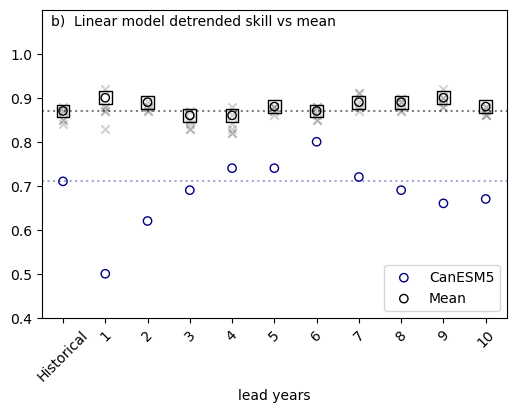

In [20]:
from scipy import stats
import matplotlib.transforms as transforms

################################ Linear model ############################

plt.figure(figsize = (6,4))
ax = plt.subplot(1,1,1)



############## individual products versus mean as grey crosses in the background ################
c = 0    
for prd in Lin_skills.product: #
    
    
    Lin_skills.sel(product = prd)[:-1].plot.scatter( facecolors='grey', alpha = 0.35, marker = 'x')
    c = c +1

################## raw CanESM5 versus mean  ###################

CanESM5_mean[:-1].plot.scatter(facecolors='none', edgecolors='navy', label = 'CanESM5')
plt.axhline(y = CanESM5_mean.sel(lead_time = 'Historical'), alpha = 0.35 , color = 'navy', linestyle = 'dotted')

################## hindcasts trained and evaluated vs MEAN ######################

Lin_mean[:-1].plot.scatter(facecolors='none', edgecolors='k', label = 'Mean')
plt.axhline(y = Lin_mean.sel(lead_time = 'Historical'), alpha = 0.5 , color = 'k', linestyle = 'dotted')

################## Check if Lienar model hindcast skills are significantly better than the corresponding historical skill ######################

for ly in Lin_skill_dist_mean.lead_time.values:

    if Lin_mean.sel(lead_time = ly) > Lin_mean.sel(lead_time = 'Historical'): # check if there is an improvement

        p = p_value((Lin_skill_dist_mean.sel(lead_time = ly) - Lin_skill_dist_mean.sel(lead_time = 'Historical'))) # Calculate p-value 
        if np.round(p,2) <= 0.05: # fill the dot if p<0.05
            plt.scatter(Lin_mean.sel(lead_time = ly).lead_time, Lin_mean.sel(lead_time = ly), facecolors='k', edgecolors='none')

################## Check if Lienar model  skills are significantly better than the raw CanESM5 skill ######################

for ly in Lin_mean.lead_time.values[:-1]:

    ds = CanESM5_mean.sel(lead_time = ly)
    ds_corrected = Lin_mean.sel(lead_time = ly)

    if ds_corrected > ds: # check if there is an improvement
        p = p_value(Lin_skill_dist_mean.sel(lead_time = ly) - CanESM5_skill_dist_mean.sel(lead_time = ly) ) # Calculate p-value

        if np.round(p,2) <= 0.05: # plot a square around the dot if p<0.05
            plt.scatter(Lin_mean.sel(lead_time = ly).lead_time, Lin_mean.sel(lead_time = ly), facecolors='none', marker = 's', edgecolors='k', s = 85)

                                              
                      


plt.ylim([0.4,1.1])
plt.xlabel('lead years')

plt.text(0.02, 0.95, f'b)  Linear model detrended skill vs mean', transform=ax.transAxes)
ticks = np.arange(0.4,1.05,0.1)
ax.set_yticks(ticks)
plt.xticks(rotation=45)
plt.legend(loc='lower right')     


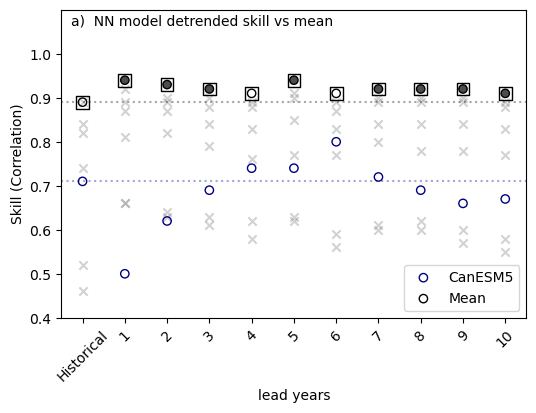

In [21]:

import matplotlib.transforms as transforms

################################ NN model ############################


plt.figure(figsize = (6,4))
ax = plt.subplot(1,1,1)



c = 0    
for prd in Lin_skills.product:
    
    
    NN_skills.sel(product = prd)[:-1].plot.scatter( facecolors='grey', alpha = 0.35, marker = 'x')
    c = c +1
    

CanESM5_mean[:-1].plot.scatter(facecolors='none', edgecolors='navy', label = 'CanESM5')
plt.axhline(y = CanESM5_mean.sel(lead_time = 'Historical'), alpha = 0.35 , color = 'navy', linestyle = 'dotted')


NN_mean[:-1].plot.scatter(facecolors='none', edgecolors='k', label = 'Mean')
plt.axhline(y = NN_mean.sel(lead_time = 'Historical'), alpha = 0.35 , color = 'k', linestyle = 'dotted')


for ly in NN_skill_dist_mean.lead_time.values:

    if NN_mean.sel(lead_time = ly) > NN_mean.sel(lead_time = 'Historical'):
        
        p = p_value((NN_skill_dist_mean.sel(lead_time = ly) - NN_skill_dist_mean.sel(lead_time = 'Historical')))
        if np.round(p,2) <= 0.05:
            plt.scatter(NN_mean.sel(lead_time = ly).lead_time, NN_mean.sel(lead_time = ly), facecolors='k', edgecolors='none', alpha = 0.70)


for ly in Lin_mean.lead_time.values[:-1]:

    ds = CanESM5_mean.sel(lead_time = ly)
    ds_corrected = NN_mean.sel(lead_time = ly)

    if ds_corrected > ds:
        p = p_value(NN_skill_dist_mean.sel(lead_time = ly) - CanESM5_skill_dist_mean.sel(lead_time = ly) )

        if np.round(p,2) <= 0.05:
            plt.scatter(NN_mean.sel(lead_time = ly).lead_time, NN_mean.sel(lead_time = ly), facecolors='none', marker = 's', edgecolors='k', s = 85)

                                              
                      
       
plt.ylabel('Skill (Correlation)')
plt.ylim([0.4,1.1])
plt.xlabel('lead years')

plt.text(0.02, 0.95, f'a)  NN model detrended skill vs mean', transform=ax.transAxes)
ticks = np.arange(0.4,1.05,0.1)

ax.set_yticks(ticks)
plt.xticks(rotation=45)
plt.legend(loc='lower right')     


# Figure 4

Maps and patterns of improvement

In [15]:
## This function calculates p_values at each grid cell

def _pvalue(ds):

    return ds.where(ds<0).count(['sample'])/len(ds)

## sort coordinates in the order of time X lat X lon

def sort_coords(ds):
    return ds.transpose('time','lat','lon')

## this function calcualtes the percentage of global ocean where there is significant improvement.

def sig_area(sig, ref):
    return 100*area.where(sig<= 0.05).sum(['lat','lon'])/ (area - ref + ref).sum(['lat','lon'])

Load hindcast/historical/assimilation annual mean anomaly data for the models trained on MEAN and evaluate vs MEAN.

In [16]:

Lin_ly_dict, Lin_hist, Lin_assim, NN_ly_dict, NN_hist, NN_assim, ref = hindcast_data('Mean', 'Mean')

Do bootstraping at each grid cell for patterns of significance for detrended ocean carbon flux maps:

In [17]:
######################### Detrend raw CanESM5 ensemble means ##########################

fgco2_hist_ts = detrend(fgco2_hist.mean('member'))
# fgco2_assim_ts = detrend(fgco2_assim)

# ly_dict_ts  = {}
# for key, ds in ly_dict.items():
    
#     ly_dict_ts[key] = detrend(ds.mean('member'))

########################### detrend statistical models data ########################
    
# NN_ly_dict_ts  = {}
# for key, ds in NN_ly_dict.items():
    
#     NN_ly_dict_ts[key] = detrend(ds)
    
# Lin_ly_dict_ts  = {}
# for key, ds in Lin_ly_dict.items():
    
#     Lin_ly_dict_ts[key] = detrend(sort_coords(ds))

Lin_hist = sort_coords(Lin_hist)
# Lin_assim = sort_coords(Lin_assim)

############################## Do bootstraping to acquire distributions #####################

# NN_ly_dist = {}
# Lin_ly_dist = {}
# ly_dist = {}

# NN_assim_dist = {}
# Lin_assim_dist = {}
# CanESM5_assim_dist = {}

NN_hist_dist = {}
Lin_hist_dist = {}
CanESM5_hist_dist = {}


obs_ts = detrend(ref) ## detrend reference observational data

from tqdm import tqdm    
for it in tqdm(range(1000)):
    
    time_sample = randgen_lag_corr(30) ## generate random time indexes with 5 years lag in between elements
    
    Obs = obs_ts[time_sample,:,:] ## Shuffle observational refrence map at each grid cell in time
       
    NN_hist_dist[it] = np.round(xr.corr(detrend(NN_hist)[time_sample,:,:], Obs, dim = 'time'),2)  ## Shuffle NN historical map at each grid cell in time with same indexes and correlate with shuffled observation
    Lin_hist_dist[it] = np.round(xr.corr(detrend(Lin_hist)[time_sample,:,:], Obs, dim = 'time'),2) ## Shuffle Linear historical map at each grid cell in time with same indexes and correlate with shuffled observation
    CanESM5_hist_dist[it] = np.round(xr.corr(fgco2_hist_ts[time_sample,:,:],Obs, dim = 'time'),2)  ## Shuffle CanESM ensemble mean historical map at each grid cell in time with same indexes and correlate with shuffled observation
    
#     NN_assim_dist[it] = np.round(xr.corr(detrend(NN_assim)[time_sample,:,:], Obs, dim = 'time'),2)  ## same as above for assimilation maps
#     Lin_assim_dist[it] = np.round(xr.corr(detrend(Lin_assim)[time_sample,:,:], Obs, dim = 'time'),2)
#     CanESM5_assim_dist[it] = np.round(xr.corr(fgco2_assim_ts[time_sample,:,:],Obs, dim = 'time'),2) 
    

## bootstraping for hindcasts on lead years 1,2,5, and 10 same as above

#     NN_ly_dist[it] = xr.concat([np.round(xr.corr(NN_ly_dict_ts[ly][time_sample,:,:],Obs, dim = 'time'),2) for ly in [1,2,5,10]], dim = 'lead_time').assign_coords(lead_time = [1,2,5,10])
#     Lin_ly_dist[it] = xr.concat([np.round(xr.corr(Lin_ly_dict_ts[ly][time_sample,:,:],Obs, dim = 'time'),2) for ly in [1,2,5,10]], dim = 'lead_time').assign_coords(lead_time = [1,2,5,10])
#     ly_dist[it] = xr.concat([np.round(xr.corr(ly_dict_ts[ly][time_sample,:,:],Obs, dim = 'time'),2) for ly in [1,2,5,10]], dim = 'lead_time').assign_coords(lead_time = [1,2,5,10])



### Concatenate the 1000 samples for hindcasts 

# NN_ly_dist  = xr.concat(list(NN_ly_dist.values()), dim = 'sample')  
# Lin_ly_dist  = xr.concat(list(Lin_ly_dist.values()), dim = 'sample')
# ly_dist  = xr.concat(list(ly_dist.values()), dim = 'sample')

### Concatenate the 1000 samples for historical 

NN_hist_dist  = xr.concat(list(NN_hist_dist.values()), dim = 'sample')
Lin_hist_dist  = xr.concat(list(Lin_hist_dist.values()), dim = 'sample')
CanESM5_hist_dist  = xr.concat(list(CanESM5_hist_dist.values()), dim = 'sample')

### Concatenate the 1000 samples for assimilation 

# NN_assim_dist  = xr.concat(list(NN_assim_dist.values()), dim = 'sample')
# Lin_assim_dist  = xr.concat(list(Lin_assim_dist.values()), dim = 'sample')
# CanESM5_assim_dist  = xr.concat(list(CanESM5_assim_dist.values()), dim = 'sample')

100%|██████████| 1000/1000 [16:15<00:00,  1.02it/s]


Calculate p values at each grid cell for the difference in correlations with raw CanESM5 scores.

In [18]:

NN_hist_p_values = _pvalue(NN_hist_dist - CanESM5_hist_dist)
Lin_hist_p_values = _pvalue(Lin_hist_dist - CanESM5_hist_dist)

# NN_assim_p_values = _pvalue(NN_assim_dist - CanESM5_assim_dist)
# Lin_assim_p_values = _pvalue(Lin_assim_dist - CanESM5_assim_dist)


# for ly in [1,2,5,10]:

#     NN_ly_p_values[ly] = _pvalue(NN_ly_dist[it] - ly_dist[it])
#     Lin_ly_p_values[ly] = _pvalue(Lin_ly_dist[it] - ly_dist[it])

In [19]:
Lin_assim_p_values = xr.open_dataset(f'/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Lin_assim_p_values.nc').__xarray_dataarray_variable__
NN_assim_p_values = xr.open_dataset(f'/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/NN_assim_p_values.nc').__xarray_dataarray_variable__
# Lin_hist_p_values = xr.open_dataset(f'Lin_hist_p_values.nc').__xarray_dataarray_variable__
# NN_hist_p_values = xr.open_dataset(f'NN_hist_p_values.nc').__xarray_dataarray_variable__

NN_ly_p_values = {}
Lin_ly_p_values = {}
for ly in [1,2,5,10]:
    NN_ly_p_values[ly] = xr.open_dataset(f'/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/NN_ly{ly}_p_values.nc').__xarray_dataarray_variable__
    Lin_ly_p_values[ly] = xr.open_dataset(f'/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Lin_ly{ly}_p_values.nc').__xarray_dataarray_variable__

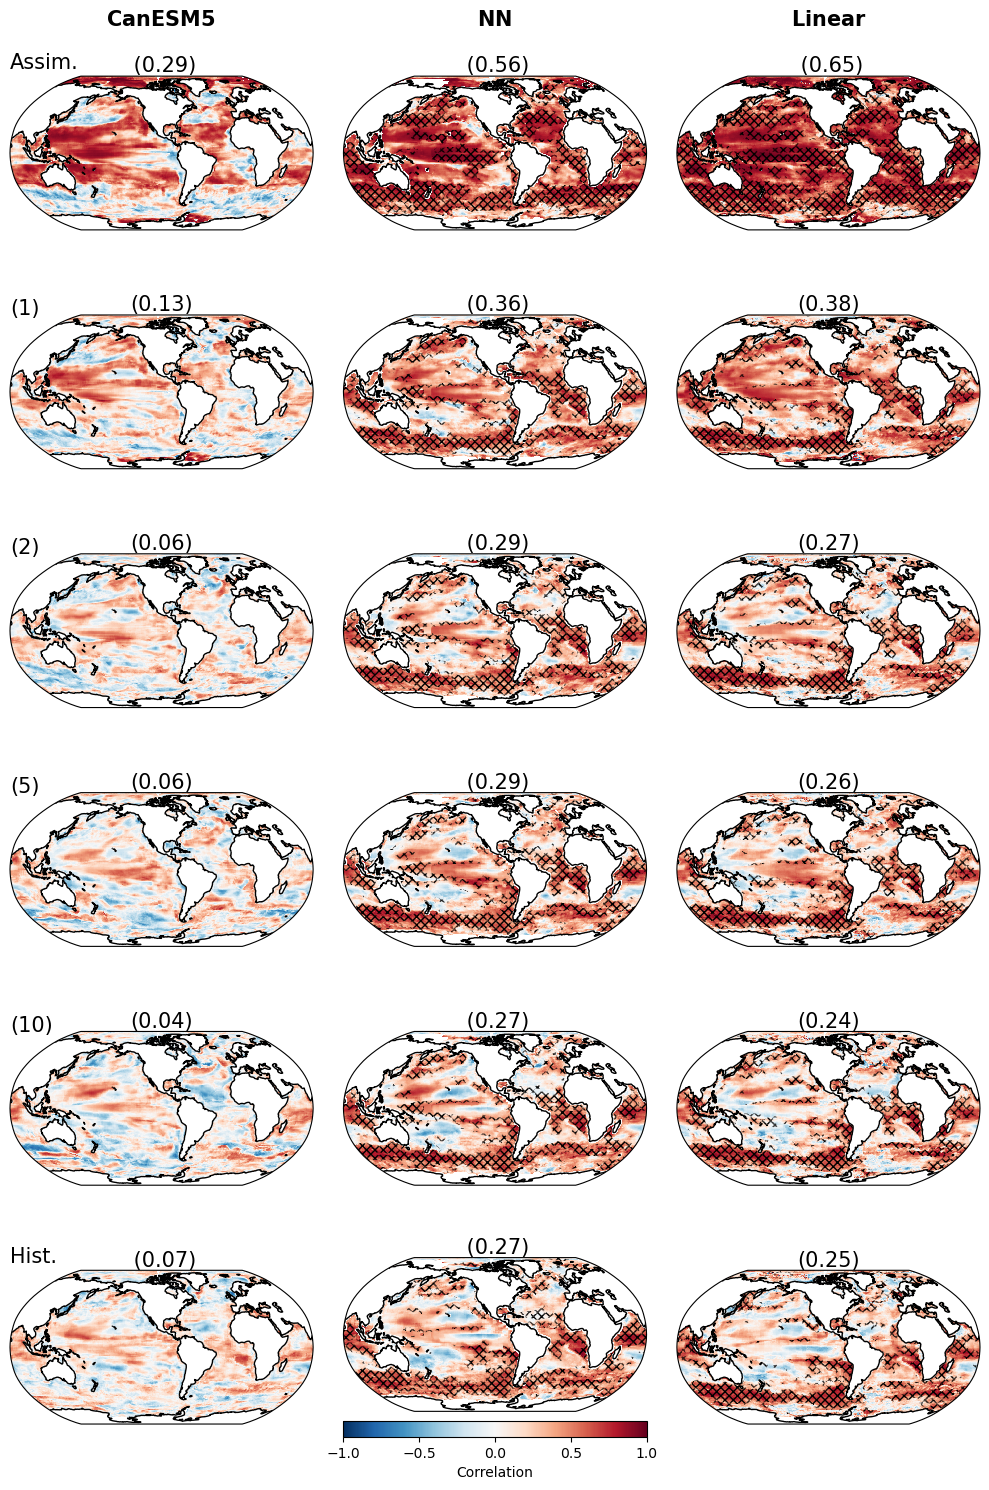

In [20]:

import matplotlib.transforms as transforms
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable

#### Load data for models trained on MEAN and load MEAN

Lin_ly_dict, Lin_hist, Lin_assim, NN_ly_dict, NN_hist, NN_assim, ref = hindcast_data('Mean', 'Mean')




plt.figure(figsize = (10,15))


###################### plot assimilation correlations with MEAN for detrended ocean carbon flux ############################
CanESM5_obs = xr.corr(detrend(fgco2_assim), detrend(ref) , dim = 'time')  ## CanESM5 vs obs correaltion maps
NN_obs = xr.corr(detrend(NN_assim),  detrend(ref) , dim = 'time') ## NN model vs obs correaltion maps
Lin_obs = xr.corr(detrend(Lin_assim),  detrend(ref) , dim = 'time') ## Linear model vs obs correaltion maps

ax = plt.subplot(6,3,1 , projection=ccrs.Robinson(central_longitude=260)) ## Raw CanESM5
cb= ax.pcolormesh(CanESM5_obs.lon, CanESM5_obs.lat, CanESM5_obs, cmap=plt.cm.get_cmap('RdBu_r'),vmax = 1,vmin= -1,rasterized=True,transform=ccrs.PlateCarree())
_=ax.coastlines()
ave = (CanESM5_obs).mean().values  ## mean of correaltions 
ax.set_title(r'$\bf{CanESM5}$' + f' \n \n ({np.round(ave,2)})', fontsize=15, pad = 0.5) 
ax.text(0,1.05, f'Assim.',  fontsize=15, transform=ax.transAxes)


ax = plt.subplot(6,3,2 , projection=ccrs.Robinson(central_longitude=260)) ## NN model
cb= ax.pcolormesh(NN_obs.lon, NN_obs.lat, NN_obs, cmap=plt.cm.get_cmap('RdBu_r'),vmax = 1,vmin= -1,rasterized=True,transform=ccrs.PlateCarree())
_=ax.coastlines()
ave = (NN_obs).mean().values ## mean of correaltions 
ax.set_title(r'$\bf{NN}$' + f' \n\n ({np.round(ave,2)})', fontsize=15, pad = 0.5) 


ref_map = NN_obs - NN_obs  ## coverage reference
sig = NN_assim_p_values - ref_map ## p values maps for the correlation differences at each grid cell.
sig = sig.where(sig<= 0.05)     
plt.contourf(sig.lon, sig.lat, sig, colors='none', hatches=['XXXX'],  ## hatch grid cells where p<0.05
         transform=cartopy.crs.PlateCarree())


ax = plt.subplot(6,3,3 , projection=ccrs.Robinson(central_longitude=260)) ## Lienar model
cb= ax.pcolormesh(Lin_obs.lon, Lin_obs.lat, Lin_obs, cmap=plt.cm.get_cmap('RdBu_r'),vmax = 1,vmin= -1,rasterized=True,transform=ccrs.PlateCarree())
_=ax.coastlines()
dif = (Lin_obs).mean().values ## mean of correaltions 
ax.set_title(r'$\bf{Linear}$' + f' \n \n ({np.round(dif,2)})', fontsize=15, pad = 0.5) 

ref_map = Lin_obs - Lin_obs ## coverage reference
sig = Lin_assim_p_values - ref_map ## p values maps for the correlation differences at each grid cell.
sig = sig.where(sig<= 0.05)
plt.contourf(sig.lon, sig.lat, sig, colors='none', hatches=['XXXX'], ## hatch grid cells where p<0.05
         transform=cartopy.crs.PlateCarree())


###################### plot hindcast correlations with MEAN for detrended ocean carbon flux ############################  
j = 4

for lt in [1,2,5,10]:
    
        
    CanESM5_obs = xr.corr(detrend(ly_dict[lt].mean('member').drop('depth')), detrend(ref) , dim = 'time')
    NN_obs = xr.corr(detrend(NN_ly_dict[lt]),  detrend(ref) , dim = 'time')
    Lin_obs = xr.corr(detrend(Lin_ly_dict[lt]),  detrend(ref) , dim = 'time')
    
        
    ax = plt.subplot(6,3,j , projection=ccrs.Robinson(central_longitude=260))
    cb= ax.pcolormesh(CanESM5_obs.lon, CanESM5_obs.lat, CanESM5_obs, cmap=plt.cm.get_cmap('RdBu_r'),vmax = 1,vmin= -1,rasterized=True,transform=ccrs.PlateCarree())
    _=ax.coastlines()
    ave = (CanESM5_obs).mean().values
    ax.set_title(f'({np.round(ave,2)})', fontsize=15, pad = 0.5)
    ax.text(0,1, f'({lt})',  fontsize=15, transform=ax.transAxes)


    ax = plt.subplot(6,3,j+1 , projection=ccrs.Robinson(central_longitude=260))
    cb= ax.pcolormesh(NN_obs.lon, NN_obs.lat, NN_obs, cmap=plt.cm.get_cmap('RdBu_r'),vmax = 1,vmin= -1,rasterized=True,transform=ccrs.PlateCarree())
    _=ax.coastlines()
    ave = (NN_obs).mean().values
    ax.set_title(f'\n ({np.round(ave,2)})', fontsize=15, pad = 0.5)
    
    ref_map = NN_obs - NN_obs
    sig = NN_ly_p_values[ly] - ref_map
    sig = sig.where(sig<= 0.05)
    plt.contourf(sig.lon, sig.lat, sig, colors='none', hatches=['XXXX'],
             transform=cartopy.crs.PlateCarree())


    ax = plt.subplot(6,3,j+2 , projection=ccrs.Robinson(central_longitude=260))
    cb= ax.pcolormesh(Lin_obs.lon, Lin_obs.lat, Lin_obs, cmap=plt.cm.get_cmap('RdBu_r'),vmax = 1,vmin= -1,rasterized=True,transform=ccrs.PlateCarree())
    _=ax.coastlines()
    dif = (Lin_obs).mean().values
    ax.set_title(f'({np.round(dif,2)})', fontsize=15, pad = 0.5)
    
    ref_map = Lin_obs - Lin_obs
    sig = Lin_ly_p_values[ly] - ref_map
    sig = sig.where(sig<= 0.05)
    plt.contourf(sig.lon, sig.lat, sig, colors='none', hatches=['XXXX'],
             transform=cartopy.crs.PlateCarree())

    j = j+3

###################### plot historical correlations with MEAN for detrended ocean carbon flux ############################

CanESM5_obs = xr.corr(detrend(fgco2_hist.mean('member')), detrend(ref) , dim = 'time')
NN_obs = xr.corr(detrend(NN_hist),  detrend(ref) , dim = 'time')
Lin_obs = xr.corr(detrend(Lin_hist),  detrend(ref) , dim = 'time')


ax = plt.subplot(6,3,16 , projection=ccrs.Robinson(central_longitude=260))
cb= ax.pcolormesh(CanESM5_obs.lon, CanESM5_obs.lat, CanESM5_obs, cmap=plt.cm.get_cmap('RdBu_r'),vmax = 1,vmin= -1,rasterized=True,transform=ccrs.PlateCarree())
_=ax.coastlines()
ave = (CanESM5_obs).mean().values
ax.set_title( f' \n ({np.round(ave,2)})', fontsize=15, pad = 0.5) 
ax.text(0,1.05, f'Hist.',  fontsize=15, transform=ax.transAxes)



ax = plt.subplot(6,3,17 , projection=ccrs.Robinson(central_longitude=260))
cb= ax.pcolormesh(NN_obs.lon, NN_obs.lat, NN_obs, cmap=plt.cm.get_cmap('RdBu_r'),vmax = 1,vmin= -1,rasterized=True,transform=ccrs.PlateCarree())
_=ax.coastlines()
ave = (NN_obs).mean().values
ax.set_title( f' \n ({np.round(ave,2)})', fontsize=15, pad = 0.5) 

ref_map = NN_obs - NN_obs
sig = NN_hist_p_values - ref_map
sig = sig.where(sig<= 0.05)
plt.contourf(sig.lon, sig.lat, sig, colors='none', hatches=['XXXX'],
         transform=cartopy.crs.PlateCarree())

ax = plt.subplot(6,3,18 , projection=ccrs.Robinson(central_longitude=260))
cb= ax.pcolormesh(Lin_obs.lon, Lin_obs.lat, Lin_obs, cmap=plt.cm.get_cmap('RdBu_r'),vmax = 1,vmin= -1,rasterized=True,transform=ccrs.PlateCarree())
_=ax.coastlines()
dif = (Lin_obs).mean().values
ax.set_title( f'({np.round(dif,2)})', fontsize=15, pad = 0.5) 

ref_map = Lin_obs - Lin_obs
sig = Lin_hist_p_values - ref_map
sig = sig.where(sig<= 0.05)
plt.contourf(sig.lon, sig.lat, sig, colors='none', hatches=['XXXX'],
         transform=cartopy.crs.PlateCarree())

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.02)

ax = plt.subplot(6,3,17 , projection=ccrs.Robinson(central_longitude=260))
divider = make_axes_locatable(ax)
ax_cb = divider.append_axes('bottom', size="10%", pad=0.1, axes_class=plt.Axes)
cbar=plt.colorbar(cb, cax=ax_cb, orientation="horizontal")
cbar.set_label(label=r'Correlation', size=10)
cbar.ax.tick_params(labelsize=10)

Same as above but this time we calcualte the percentage where there is significant improvement on top of each panel.

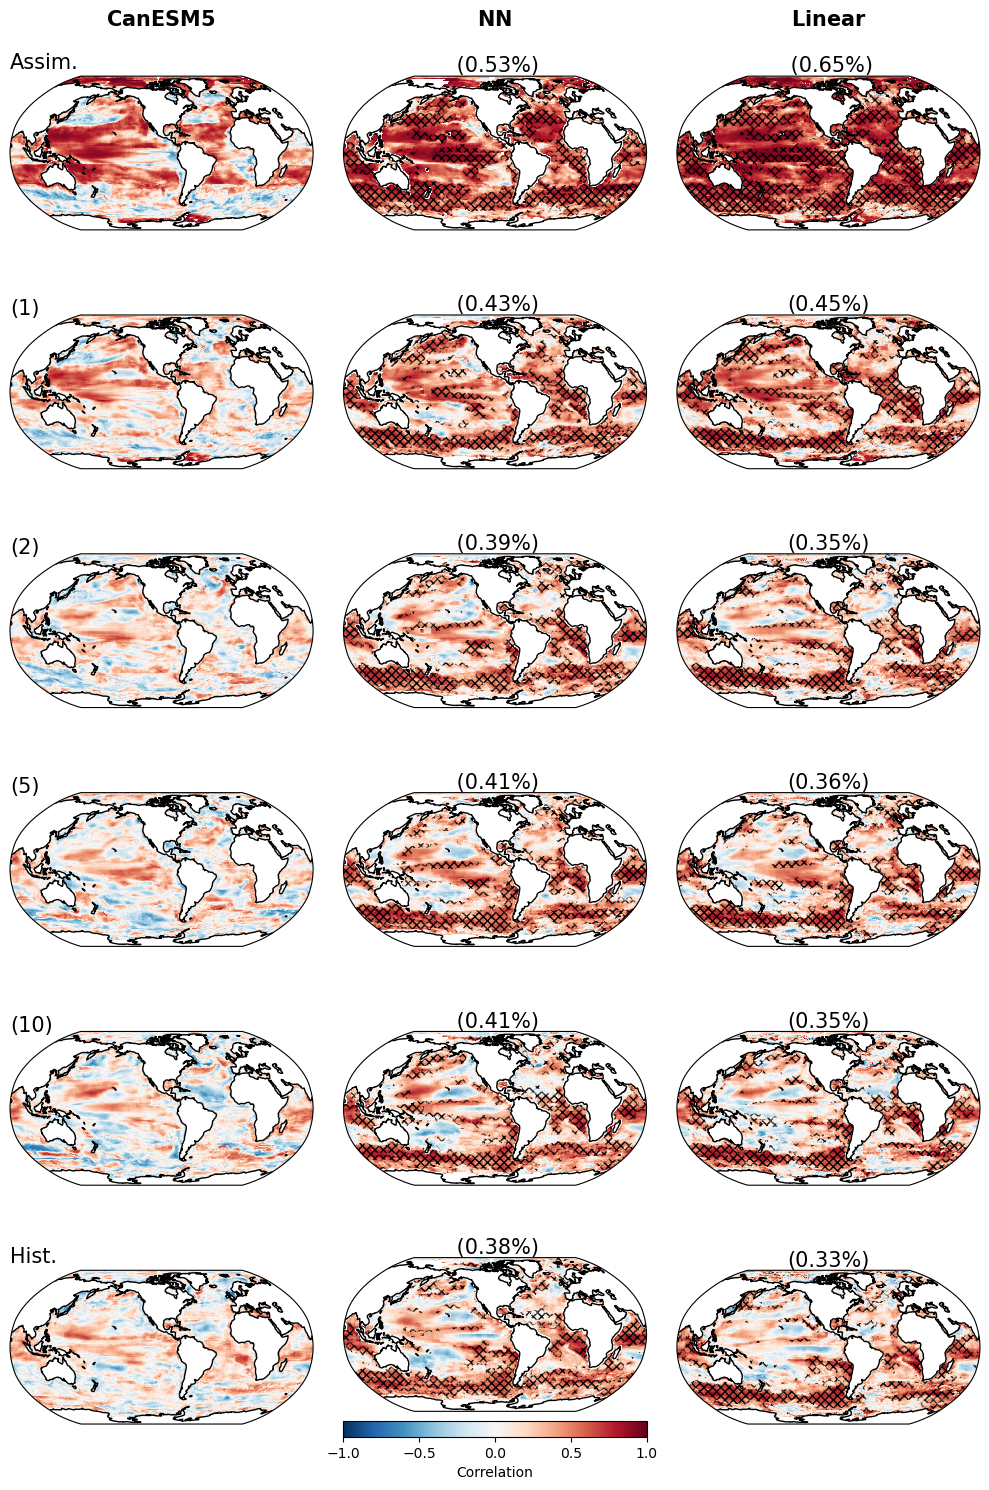

In [126]:
Lin_ly_dict, Lin_hist, Lin_assim, NN_ly_dict, NN_hist, NN_assim, ref = hindcast_data('Mean', 'Mean')


import matplotlib.transforms as transforms
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.figure(figsize = (10,15))


###################### Assim ############################
CanESM5_obs = xr.corr(detrend(fgco2_assim), detrend(ref) , dim = 'time')
NN_obs = xr.corr(detrend(NN_assim),  detrend(ref) , dim = 'time')
Lin_obs = xr.corr(detrend(Lin_assim),  detrend(ref) , dim = 'time')

ax = plt.subplot(6,3,1 , projection=ccrs.Robinson(central_longitude=260))
cb= ax.pcolormesh(CanESM5_obs.lon, CanESM5_obs.lat, CanESM5_obs, cmap=plt.cm.get_cmap('RdBu_r'),vmax = 1,vmin= -1,rasterized=True,transform=ccrs.PlateCarree())
_=ax.coastlines()
ax.set_title(r'$\bf{CanESM5}$' + f' \n \n ', fontsize=15, pad = 0.5) 
ax.text(0,1.05, f'Assim.',  fontsize=15, transform=ax.transAxes)


ref_map = NN_obs - NN_obs
sig = NN_assim_p_values - ref_map
sig = sig.where(sig<= 0.05)

ax = plt.subplot(6,3,2 , projection=ccrs.Robinson(central_longitude=260))
cb= ax.pcolormesh(NN_obs.lon, NN_obs.lat, NN_obs, cmap=plt.cm.get_cmap('RdBu_r'),vmax = 1,vmin= -1,rasterized=True,transform=ccrs.PlateCarree())
_=ax.coastlines()
ave = sig_area(sig, ref_map).values
ax.set_title(r'$\bf{NN}$' + f' \n\n ({np.round(ave,2)}%)', fontsize=15, pad = 0.5) 


plt.contourf(sig.lon, sig.lat, sig, colors='none', hatches=['XXXX'],
         transform=cartopy.crs.PlateCarree())



ref_map = Lin_obs - Lin_obs
sig = Lin_assim_p_values - ref_map
sig = sig.where(sig<= 0.05)

ax = plt.subplot(6,3,3 , projection=ccrs.Robinson(central_longitude=260))
cb= ax.pcolormesh(Lin_obs.lon, Lin_obs.lat, Lin_obs, cmap=plt.cm.get_cmap('RdBu_r'),vmax = 1,vmin= -1,rasterized=True,transform=ccrs.PlateCarree())
_=ax.coastlines()
ave = sig_area(sig, ref_map).values
ax.set_title(r'$\bf{Linear}$' + f' \n \n ({np.round(ave,2)}%)', fontsize=15, pad = 0.5) 


plt.contourf(sig.lon, sig.lat, sig, colors='none', hatches=['XXXX'],
         transform=cartopy.crs.PlateCarree())

###################### Hindcast ############################   
j = 4

for lt in [1,2,5,10]:
    
        
    CanESM5_obs = xr.corr(detrend(ly_dict[lt].mean('member').drop('depth')), detrend(ref) , dim = 'time')
    NN_obs = xr.corr(detrend(NN_ly_dict[lt]),  detrend(ref) , dim = 'time')
    Lin_obs = xr.corr(detrend(Lin_ly_dict[lt]),  detrend(ref) , dim = 'time')
    
        
    ax = plt.subplot(6,3,j , projection=ccrs.Robinson(central_longitude=260))
    cb= ax.pcolormesh(CanESM5_obs.lon, CanESM5_obs.lat, CanESM5_obs, cmap=plt.cm.get_cmap('RdBu_r'),vmax = 1,vmin= -1,rasterized=True,transform=ccrs.PlateCarree())
    _=ax.coastlines()
    ax.text(0,1, f'({lt})',  fontsize=15, transform=ax.transAxes)


    ref_map = NN_obs - NN_obs
    sig = NN_ly_p_values[lt] - ref_map
    sig = sig.where(sig<= 0.05)
    
    ax = plt.subplot(6,3,j+1 , projection=ccrs.Robinson(central_longitude=260))
    cb= ax.pcolormesh(NN_obs.lon, NN_obs.lat, NN_obs, cmap=plt.cm.get_cmap('RdBu_r'),vmax = 1,vmin= -1,rasterized=True,transform=ccrs.PlateCarree())
    _=ax.coastlines()
    ave = sig_area(sig, ref_map).values
    ax.set_title(f'\n ({np.round(ave,2)}%)', fontsize=15, pad = 0.5)
    

    plt.contourf(sig.lon, sig.lat, sig, colors='none', hatches=['XXXX'],
             transform=cartopy.crs.PlateCarree())


    
    ref_map = Lin_obs - Lin_obs
    sig = Lin_ly_p_values[lt] - ref_map
    sig = sig.where(sig<= 0.05)
    
    ax = plt.subplot(6,3,j+2 , projection=ccrs.Robinson(central_longitude=260))
    cb= ax.pcolormesh(Lin_obs.lon, Lin_obs.lat, Lin_obs, cmap=plt.cm.get_cmap('RdBu_r'),vmax = 1,vmin= -1,rasterized=True,transform=ccrs.PlateCarree())
    _=ax.coastlines()
    ave = sig_area(sig, ref_map).values
    ax.set_title(f'({np.round(ave,2)}%)', fontsize=15, pad = 0.5)
    

    plt.contourf(sig.lon, sig.lat, sig, colors='none', hatches=['XXXX'],
             transform=cartopy.crs.PlateCarree())

    j = j+3

###################### Historical ############################  

CanESM5_obs = xr.corr(detrend(fgco2_hist.mean('member')), detrend(ref) , dim = 'time')
NN_obs = xr.corr(detrend(NN_hist),  detrend(ref) , dim = 'time')
Lin_obs = xr.corr(detrend(Lin_hist),  detrend(ref) , dim = 'time')


ax = plt.subplot(6,3,16 , projection=ccrs.Robinson(central_longitude=260))
cb= ax.pcolormesh(CanESM5_obs.lon, CanESM5_obs.lat, CanESM5_obs, cmap=plt.cm.get_cmap('RdBu_r'),vmax = 1,vmin= -1,rasterized=True,transform=ccrs.PlateCarree())
_=ax.coastlines()
ax.text(0,1.05, f'Hist.',  fontsize=15, transform=ax.transAxes)


ref_map = NN_obs - NN_obs
sig = NN_hist_p_values - ref_map
sig = sig.where(sig<= 0.05)

ax = plt.subplot(6,3,17 , projection=ccrs.Robinson(central_longitude=260))
cb= ax.pcolormesh(NN_obs.lon, NN_obs.lat, NN_obs, cmap=plt.cm.get_cmap('RdBu_r'),vmax = 1,vmin= -1,rasterized=True,transform=ccrs.PlateCarree())
_=ax.coastlines()
ave = sig_area(sig, ref_map).values
ax.set_title( f' \n ({np.round(ave,2)}%)', fontsize=15, pad = 0.5) 


plt.contourf(sig.lon, sig.lat, sig, colors='none', hatches=['XXXX'],
         transform=cartopy.crs.PlateCarree())



ref_map = Lin_obs - Lin_obs
sig = Lin_hist_p_values - ref_map
sig = sig.where(sig<= 0.05)

ax = plt.subplot(6,3,18 , projection=ccrs.Robinson(central_longitude=260))
cb= ax.pcolormesh(Lin_obs.lon, Lin_obs.lat, Lin_obs, cmap=plt.cm.get_cmap('RdBu_r'),vmax = 1,vmin= -1,rasterized=True,transform=ccrs.PlateCarree())
_=ax.coastlines()
ave = sig_area(sig, ref_map).values
ax.set_title( f'({np.round(ave,2)}%)', fontsize=15, pad = 0.5) 


plt.contourf(sig.lon, sig.lat, sig, colors='none', hatches=['XXXX'],
         transform=cartopy.crs.PlateCarree())

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.02)

ax = plt.subplot(6,3,17 , projection=ccrs.Robinson(central_longitude=260))
divider = make_axes_locatable(ax)
ax_cb = divider.append_axes('bottom', size="10%", pad=0.1, axes_class=plt.Axes)
cbar=plt.colorbar(cb, cax=ax_cb, orientation="horizontal")
cbar.set_label(label=r'Correlation', size=10)
cbar.ax.tick_params(labelsize=10)

# Figure 5

Plot forecasted annual mean global anomalies relative to 1990-2019 for the models trained on MEAN.

In [23]:
## This function allows for plotting a smaller subplot inside an original figure.

def add_subplot_axes(ax,rect,axisbg ='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    #subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
    subax = fig.add_axes([x,y,width,height])
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax




### Grab annual mean anomalies forecasted data for models trained on your SeaFLux product of choice (name) 
### as well as the observational reference (ref_name).

def forecast_data(name, ref_name):
    
    if ref_name == 'Mean':
        
        ref = sink.mean('product')   
    else:
        ref = sink.sel(product = ref_name)
        
    ref = ref.resample(time = 'Y').mean() - ref.mean('time')
    
    #################################### WATCH THE TIME ######################################################
    ## Load NN model hindcasts data over the entire time period available: e.g. lead year five we have 1990-2024.
    
    NN_ly_dict = {}
    for i in range(1,11):

        NN_ly_dict[i] = xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/NN_models/SeaFlux/{name}/Output/hindcast_{name}_annual_SOMFFN_sigmoid15_ly{i+1}_CHL_only.nc").fgco2.sel(time = slice(f'{1990}',None)) 


    ## Calculate annual mean anomalies relative to 1990-2019
    for ly in NN_ly_dict.keys():

        NN_ly_dict[ly] = (NN_ly_dict[ly].resample(time = 'Y').mean())
        NN_ly_dict[ly] = NN_ly_dict[ly] - NN_ly_dict[ly].sel(time = slice('1990','2019')).mean('time')


    #################################### WATCH THE TIME ######################################################
    ## Same as above for the Linear model

    Lin_ly_dict = {}
    for i in range(1,11):
        
        if name == 'Mean':

            Lin_ly_dict[i] = xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Linear_models/SeaFlux/MEAN/hindcast_MEAN_linear_ly{i}.nc").fgco2.sel(time = slice(f'{1990}',None)) 
         
        else:   

            Lin_ly_dict[i] = xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Linear_models/SeaFlux/{name}/hindcast_{name}_linear_ly{i}.nc").fgco2.sel(time = slice(f'{1990}',None)) 

    for ly in Lin_ly_dict.keys():


        Lin_ly_dict[ly] = (Lin_ly_dict[ly].resample(time = 'Y').mean())
        Lin_ly_dict[ly] = Lin_ly_dict[ly] - Lin_ly_dict[ly].sel(time = slice('1990','2019')).mean('time')


    #################################### Load annual meamn anomalies from assimilation runs ######################################################

    NN_assim = xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/NN_models/SeaFlux/{name}/Output/assim_{name}_annual_SOMFFN_sigmoid15_CHL_only.nc").fgco2 
    
    if name == 'Mean':
        
        Lin_assim = xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Linear_models/SeaFlux/MEAN/assim_MEAN_annual_lienar.nc").fgco2 
        
        
    else:

        Lin_assim = xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Linear_models/SeaFlux/{name}/assim_{name}_annual_lienar.nc").fgco2 

    NN_assim = NN_assim.resample(time = 'Y').mean('time') - NN_assim.mean('time')
    Lin_assim = Lin_assim.resample(time = 'Y').mean('time') - Lin_assim.mean('time')
    
    
### resample hindcasts so that future predictions are on the earliest year of initialization available. 
### That said, for 2020 forecast, we choose the last year from lead year 1, for 2021 from lead year 2, for 2022, 
### from lead year 3 and so on. For 1990-2019, we use assimilation run. 

    temp = xr.concat([Lin_ly_dict[i].isel(time = np.arange(-1,0)) for i in range(1,11)], 'time')
    Lin_forecast = xr.concat([Lin_assim , temp], 'time')  
    
    temp = xr.concat([NN_ly_dict[i].isel(time = np.arange(-1,0)) for i in range(1,11)], 'time')
    NN_forecast = xr.concat([NN_assim , temp], 'time')
    
    return NN_forecast, Lin_forecast, ref

Load NN and Linear forecasts for the model trained on MEAN.

In [24]:
NN_forecast, Lin_forecast, ref = forecast_data('Mean', 'Mean')

Load raw and bias corrected CanESM5 forecast and resample like above. These are bias corrected fgco2 data realtive to MEAN.
You can achieve this by adjusting the code in scripts/CanESM5_data.py

In [25]:
Can_forecast = {}

for ly in range(1,11):
    
    Can_forecast[ly]= xr.open_dataset(f'/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/CanESM5_forecast/CanESM5_fgco2_ly{ly}_EM_bias_corrected_to_Mean.nc').__xarray_dataarray_variable__
    Can_forecast[ly] = Can_forecast[ly] - Can_forecast[ly].sel(time = slice('1990','2019')).mean('time')
    
CanESM5_forecast = xr.concat([Can_forecast[i].isel(time = np.arange(-1,0)) for i in range(1,11)], 'time')
CanESM5_forecast = xr.concat([fgco2_assim, CanESM5_forecast], 'time')


unit_change = 60*60*24*365 * 1000 /12
raw_Can_forecast = {}
for ly in range(1,11):
    raw_Can_forecast[ly] = xr.open_dataset(f'/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/CanESM5_forecast/CanESM5_fgco2_ly{ly}_EM.nc').fgco2 * -1 * unit_change
    raw_Can_forecast[ly] = raw_Can_forecast[ly] - raw_Can_forecast[ly].sel(time = slice('1990','2019')).mean('time')
    
raw_Can_forecast = xr.concat([raw_Can_forecast[i].isel(time = np.arange(-1,0)) for i in range(1,11)], 'time')
raw_Can_forecast = xr.concat([fgco2_assim, raw_Can_forecast], 'time')    

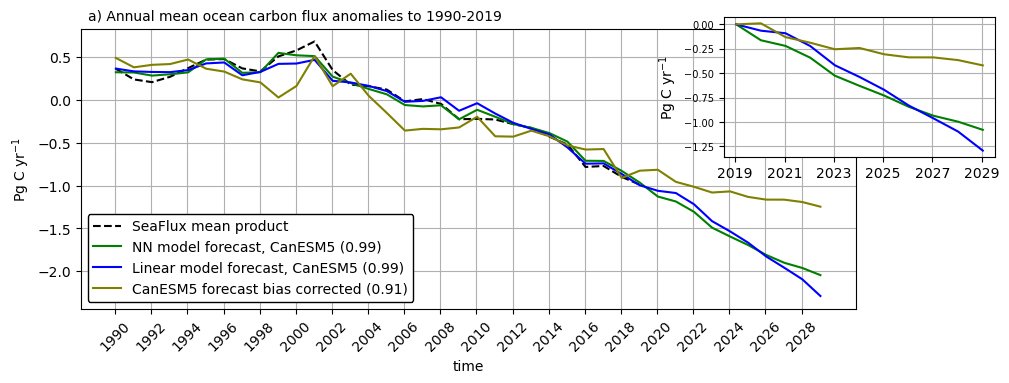

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.transforms as transforms


ticks = [cftime.DatetimeNoLeap(year, 12, 16, 0, 0, 0, 0, has_year_zero=True) for year in range(1990,2030,2)]
labels = np.arange(1990,2030,2)

plt.figure(figsize = (10,8))

ax = plt.subplot(2,1,1)    

### Plot global MEAN timeseries
ds1 = to_pgyr((ref))
ds1.plot(color = 'k',linestyle = 'dashed', label = 'SeaFlux mean product')


### Plot global NN forecast timeseries adjusted based on the area coverage of MEAN
ds = to_pgyr(NN_forecast)*Area(ref).mean().values/Area(NN_forecast)
corr = xr.corr(ds, ds1, dim = 'time').values
ds.plot(color = 'g', label = f'NN model forecast, CanESM5 ({np.round(corr,2)})')


### Plot global Linear forecast timeseries adjusted based on the area coverage of MEAN
ds = to_pgyr(Lin_forecast)*Area(ref).mean().values/Area(Lin_forecast)
corr = xr.corr(ds, ds1, dim = 'time').values
ds.plot(color = 'b', label = f'Linear model forecast, CanESM5 ({np.round(corr,2)})')

### Plot global bias corrected CanESM5 forecast timeseries adjusted based on the area coverage of MEAN
ds = to_pgyr(CanESM5_forecast)*Area(ref).mean().values/Area(CanESM5_forecast)
corr = xr.corr(ds, ds1, dim = 'time').values
ds.plot(color = 'olive', label = f'CanESM5 forecast bias corrected ({np.round(corr,2)})')



plt.ylabel(r'Pg C yr$^{-1}$')
plt.xlabel('time')
legend = plt.legend( loc = 'lower left', framealpha = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('k')
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation = 45)
plt.title('')
plt.grid('on')
ax.text(0.01,1.03, 'a) Annual mean ocean carbon flux anomalies to 1990-2019', transform=ax.transAxes)




rect = [0.83,0.542,0.35,0.5]
ax1 = add_subplot_axes(ax,rect)
ticks = [cftime.DatetimeNoLeap(year, 12, 16, 0, 0, 0, 0, has_year_zero=True) for year in range(2019,2030,2)]
labels = np.arange(2019,2030,2)

### Plot forecasted changes relative to 2019 from each of the three timeseries above in a small window within the figure above.


ds = to_pgyr(NN_forecast)*Area(ref).mean().values/Area(NN_forecast)
ds = ds.sel(time = slice('2019','2030')) - ds.sel(time = slice('2019','2019')).values
ds.plot(color = 'g')



ds = to_pgyr(Lin_forecast)*Area(ref).mean().values/Area(Lin_forecast)
ds = ds.sel(time = slice('2019','2030')) - ds.sel(time = slice('2019','2019')).values
ds.plot(color = 'b')


ds = to_pgyr(CanESM5_forecast)*Area(ref).mean().values/Area(CanESM5_forecast)
ds = ds.sel(time = slice('2019','2030')) - ds.sel(time = slice('2019','2019')).values
ds.plot(color = 'olive', label = f'CanESM5 forecast bias corrected')




ax1.set_title('')
ax1.set_xticks(ticks, fontsize=20)
ax1.set_xticklabels(labels, fontsize=10)
ax1.set_xlabel('')
ax1.set_ylabel(r'Pg C yr$^{-1}$')
ax1.grid('on')


